# Late Delivery Risk Prediction & ETA Correction

This notebook builds a late delivery risk prediction system with venue-specific ETA corrections.

**Goal**: Predict late delivery risk and apply intelligent corrections to ETA estimates.

**Approach**:
1. **Binary Classification**: Predict if delivery will exceed upper estimate
2. **Venue-Specific Buffers**: Compute correction buffers from training data only
3. **Risk-Based Correction**: Apply buffers when late risk exceeds threshold
4. **Evaluation**: Measure both classification performance and ETA accuracy improvement

**Target Variable**: 
- `late_flag = 1` if `actual_delivery_time > estimated_upper` else `0`

**Key Features**:
- `h3_distance_km` - Geographic distance
- `distance_x_weather` - Distance × Weather interaction
- `venue_friction_score` - Venue quality indicator  
- `courier_supply_index` - Fleet availability
- `precipitation` - Weather conditions
- `item_count` - Order size
- `hour` - Time of day
- `order_category` - Order type

## 1. Setup and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import xgboost as xgb
import warnings
import os
import json
from datetime import datetime

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"LightGBM version: {lgb.__version__}")

✓ Libraries imported successfully
Pandas version: 2.2.3
NumPy version: 2.2.6
LightGBM version: 4.6.0


In [ ]:
MODEL_OUTPUT_DIR = '../outputs/models'
IMAGE_OUTPUT_DIR = '../outputs/images/models'

os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(IMAGE_OUTPUT_DIR, exist_ok=True)

def save_figure(filename, dpi=300, bbox_inches='tight'):
    filepath = os.path.join(IMAGE_OUTPUT_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Saved figure: {filename}")

print(f"Output directories configured:")
print(f"  - Models: {MODEL_OUTPUT_DIR}")
print(f"  - Images: {IMAGE_OUTPUT_DIR}")

✓ Output directories configured:
  - Models: ../outputs/models
  - Images: ../outputs/images/models


## 2. Load Cleaned Data

In [ ]:
print("Loading datasets...")

train_df = pd.read_csv('../data/train.csv')
val_df = pd.read_csv('../data/val.csv')
test_df = pd.read_csv('../data/test.csv')

print(f"Training set: {len(train_df):,} rows")
print(f"Validation set: {len(val_df):,} rows")
print(f"Test set: {len(test_df):,} rows")
print(f"\nTotal: {len(train_df) + len(val_df) + len(test_df):,} rows")

required_features = ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score', 
                     'distance_x_weather', 'courier_supply_index', 'precipitation', 
                     'item_count', 'hour', 'order_category', 'venue_location_h3_index']
target_col = 'actual_delivery_time_minutes'

missing_features = [f for f in required_features if f not in train_df.columns]
if missing_features:
    print(f"\nWARNING: Missing features: {missing_features}")
    print("Run data_cleaning_pipeline.ipynb first to create engineered features")
else:
    print(f"\nAll required features present")

print(f"\nTarget variable: {target_col}")
print(f"Training target - Mean: {train_df[target_col].mean():.2f} min, Std: {train_df[target_col].std():.2f} min")
print(f"Validation target - Mean: {val_df[target_col].mean():.2f} min, Std: {val_df[target_col].std():.2f} min")
print(f"Test target - Mean: {test_df[target_col].mean():.2f} min, Std: {test_df[target_col].std():.2f} min")

Loading datasets...
✓ Training set: 16,705 rows
✓ Validation set: 3,580 rows
✓ Test set: 3,580 rows

Total: 23,865 rows

⚠️  Missing features: ['hour']
Available columns: ['order_placed_at_utc', 'order_category', 'item_count', 'actual_delivery_time_minutes', 'estimated_delivery_time_lower_minutes', 'estimated_delivery_time_upper_minutes', 'venue_location_h3_index', 'customer_location_h3_index', 'courier_supply_index', 'precipitation', 'estimate_width', 'estimate_midpoint', 'h3_grid_distance', 'h3_distance_km', 'venue_friction_score', 'distance_x_weather']

📋 Available columns (16):
  - actual_delivery_time_minutes
  - courier_supply_index
  - customer_location_h3_index
  - distance_x_weather
  - estimate_midpoint
  - estimate_width
  - estimated_delivery_time_lower_minutes
  - estimated_delivery_time_upper_minutes
  - h3_distance_km
  - h3_grid_distance
  - item_count
  - order_category
  - order_placed_at_utc
  - precipitation
  - venue_friction_score
  - venue_location_h3_index


## 3. Create Late Delivery Target & Prepare Features

In [ ]:
def create_late_target(df):
    """Create binary late delivery target."""
    df_copy = df.copy()
    df_copy['late_flag'] = (df_copy['actual_delivery_time_minutes'] > 
                            df_copy['estimated_delivery_time_upper_minutes']).astype(int)
    
    if 'order_placed_at_utc' in df_copy.columns and 'hour' not in df_copy.columns:
        df_copy['order_placed_at_utc'] = pd.to_datetime(df_copy['order_placed_at_utc'])
        df_copy['hour'] = df_copy['order_placed_at_utc'].dt.hour
    
    return df_copy

def prepare_features(df, label_encoder=None, is_train=True):
    """Prepare features for modeling."""
    df_copy = df.copy()
    
    feature_cols = ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score', 
                    'distance_x_weather', 'courier_supply_index', 'precipitation', 
                    'item_count', 'hour', 'order_category',
                    'estimated_delivery_time_lower_minutes',
                    'estimated_delivery_time_upper_minutes']
    
    available_features = [col for col in feature_cols if col in df_copy.columns]
    missing_features = [col for col in feature_cols if col not in df_copy.columns]
    
    if missing_features:
        print(f"Warning: Missing features: {missing_features}")
        print(f"Using available features: {available_features}")
    
    X = df_copy[available_features].copy()
    
    X['h3_distance_km'] = X['h3_distance_km'].fillna(X['h3_distance_km'].median())
    X['h3_grid_distance'] = X['h3_grid_distance'].fillna(X['h3_grid_distance'].median())
    X['venue_friction_score'] = X['venue_friction_score'].fillna(X['venue_friction_score'].median())
    X['distance_x_weather'] = X['distance_x_weather'].fillna(0)
    X['courier_supply_index'] = X['courier_supply_index'].fillna(X['courier_supply_index'].median())
    X['precipitation'] = X['precipitation'].fillna(0)
    X['item_count'] = X['item_count'].fillna(X['item_count'].median())
    X['hour'] = X['hour'].fillna(12)
    X['estimated_delivery_time_lower_minutes'] = X['estimated_delivery_time_lower_minutes'].fillna(
        X['estimated_delivery_time_lower_minutes'].median())
    X['estimated_delivery_time_upper_minutes'] = X['estimated_delivery_time_upper_minutes'].fillna(
        X['estimated_delivery_time_upper_minutes'].median())
    
    if is_train:
        label_encoder = LabelEncoder()
        X['order_category'] = label_encoder.fit_transform(X['order_category'].astype(str))
    else:
        X['order_category'] = label_encoder.transform(X['order_category'].astype(str))
    
    if 'late_flag' in df_copy.columns and 'actual_delivery_time_minutes' in df_copy.columns:
        y_class = df_copy['late_flag'].values
        y_reg = df_copy['actual_delivery_time_minutes'].values
    else:
        y_class = None
        y_reg = None
    
    return X, y_class, y_reg, label_encoder

print("Creating late delivery targets...\n")

train_df = create_late_target(train_df)
val_df = create_late_target(val_df)
test_df = create_late_target(test_df)

print(f"Late Delivery Rates:")
print(f"  Training:   {train_df['late_flag'].mean()*100:.2f}% ({train_df['late_flag'].sum():,} / {len(train_df):,})")
print(f"  Validation: {val_df['late_flag'].mean()*100:.2f}% ({val_df['late_flag'].sum():,} / {len(val_df):,})")
print(f"  Test:       {test_df['late_flag'].mean()*100:.2f}% ({test_df['late_flag'].sum():,} / {len(test_df):,})")

print(f"\nPreparing features...\n")

X_train, y_train_class, y_train_reg, le = prepare_features(train_df, is_train=True)
X_val, y_val_class, y_val_reg, _ = prepare_features(val_df, label_encoder=le, is_train=False)
X_test, y_test_class, y_test_reg, _ = prepare_features(test_df, label_encoder=le, is_train=False)

print(f"Training features: {X_train.shape}")
print(f"Validation features: {X_val.shape}")
print(f"Test features: {X_test.shape}")

print(f"\nFeature columns: {list(X_train.columns)}")
print(f"\nActual delivery time statistics (training):")
print(f"  Mean: {y_train_reg.mean():.2f} minutes")
print(f"  Median: {np.median(y_train_reg):.2f} minutes")
print(f"  Std: {y_train_reg.std():.2f} minutes")

Creating late delivery targets...

Late Delivery Rates:
  Training:   35.83% (5,986 / 16,705)
  Validation: 33.21% (1,189 / 3,580)
  Test:       34.80% (1,246 / 3,580)

Preparing features...

✓ Training features: (16705, 11)
✓ Validation features: (3580, 11)
✓ Test features: (3580, 11)

Feature columns: ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score', 'distance_x_weather', 'courier_supply_index', 'precipitation', 'item_count', 'hour', 'order_category', 'estimated_delivery_time_lower_minutes', 'estimated_delivery_time_upper_minutes']

Actual delivery time statistics (training):
  Mean: 34.21 minutes
  Median: 30.88 minutes
  Std: 16.24 minutes


## 4. Compute Venue-Specific Correction Buffers (Training Data Only)

COMPUTING VENUE-SPECIFIC CORRECTION BUFFERS (TRAINING DATA ONLY)

✓ Venue buffers computed from training data:
  • Total unique venues: 134
  • Venues with ≥5 orders: 113 (84.3%)
  • Average buffer (sufficient data): 4.58 minutes
  • Global fallback buffer: 3.93 minutes
  • Buffer range: [0.23, 43.21] minutes

✓ Venue buffers saved to: venue_buffers.json
✓ Saved figure: venue_buffer_distribution.png


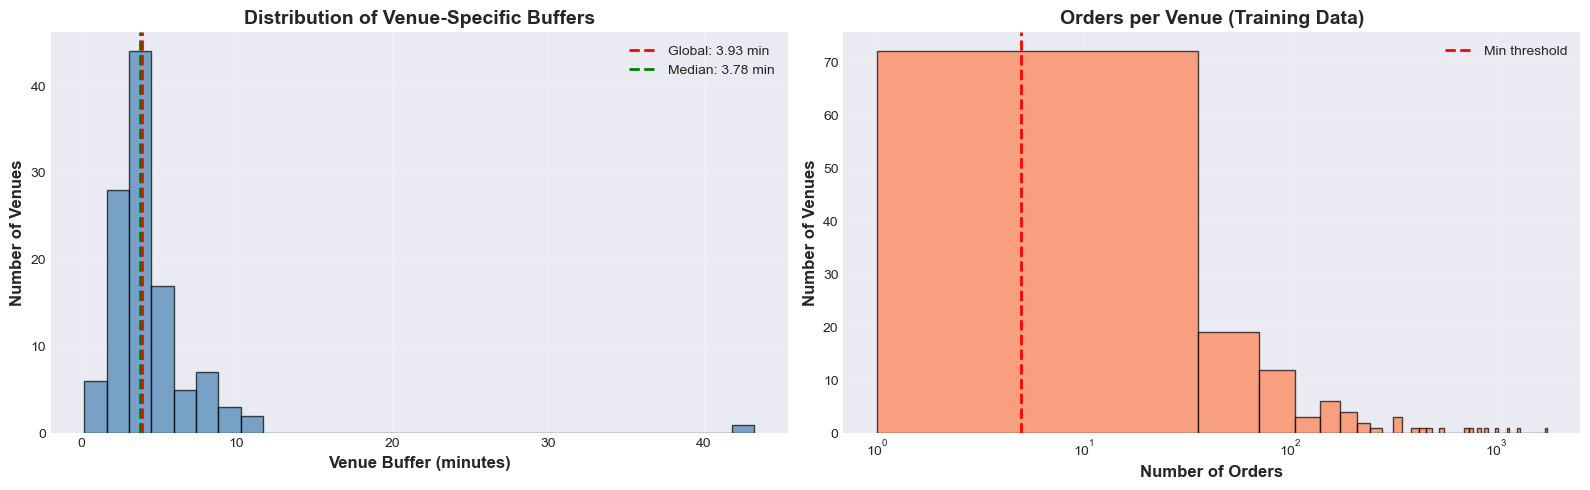

In [ ]:
print("="*80)
print("COMPUTING VENUE-SPECIFIC CORRECTION BUFFERS (TRAINING DATA ONLY)")
print("="*80)

def compute_venue_buffers(df, min_orders=5):
    """Compute venue-specific late overage buffers from training data."""
    df_copy = df.copy()
    df_copy['late_overage'] = np.maximum(0, 
        df_copy['actual_delivery_time_minutes'] - df_copy['estimated_delivery_time_upper_minutes'])
    
    venue_stats = df_copy.groupby('venue_location_h3_index')['late_overage'].agg([
        ('mean_overage', 'mean'),
        ('order_count', 'size')
    ]).reset_index()
    
    global_buffer = df_copy['late_overage'].mean()
    
    venue_buffers = {}
    for _, row in venue_stats.iterrows():
        venue_id = row['venue_location_h3_index']
        overage = row['mean_overage']
        count = row['order_count']
        
        if count >= min_orders:
            venue_buffers[venue_id] = overage
    
    print(f"\nComputed buffers for {len(venue_buffers):,} venues (with >= {min_orders} orders)")
    print(f"Global buffer for low-volume venues: {global_buffer:.2f} minutes")
    print(f"\nBuffer statistics:")
    buffer_values = list(venue_buffers.values())
    print(f"  Mean: {np.mean(buffer_values):.2f} minutes")
    print(f"  Median: {np.median(buffer_values):.2f} minutes")
    print(f"  Min: {np.min(buffer_values):.2f} minutes")
    print(f"  Max: {np.max(buffer_values):.2f} minutes")
    
    return venue_buffers, global_buffer

venue_buffers, global_buffer = compute_venue_buffers(train_df, min_orders=5)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
buffer_values = list(venue_buffers.values())
plt.hist(buffer_values, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(np.mean(buffer_values), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(buffer_values):.2f} min')
plt.axvline(np.median(buffer_values), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(buffer_values):.2f} min')
plt.xlabel('Venue Buffer (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Venue-Specific Buffers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
order_counts = train_df.groupby('venue_location_h3_index').size().sort_values(ascending=False)
plt.hist(order_counts.values, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
plt.xlabel('Orders per Venue', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Order Volume by Venue', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
save_figure('venue_buffers_distribution.png')
plt.show()

print(f"\nVenue buffers computed from training data only (no leakage)")

## 5. Train Multiple Models and Compare Performance

TRAINING MULTIPLE LATE DELIVERY RISK PREDICTION MODELS

Class distribution:
  Training:
    Late (1): 5,986 (35.83%)
    On-time (0): 10,719 (64.17%)
  Validation:
    Late (1): 1,189 (33.21%)
    On-time (0): 2,391 (66.79%)

1. LOGISTIC REGRESSION (Baseline)
  Validation AUC: 0.6545
  Validation PR-AUC: 0.4958
  Validation Accuracy: 0.5634
  Validation Precision: 0.4110
  Validation Recall: 0.7267
  Validation F1: 0.5251

2. RANDOM FOREST
  Validation AUC: 0.6528
  Validation PR-AUC: 0.4978
  Validation Accuracy: 0.6159
  Validation Precision: 0.4408
  Validation Recall: 0.5828
  Validation F1: 0.5020

3. LIGHTGBM (Optimized)
  Class balance ratio (scale_pos_weight): 1.79
  Negative samples: 10,719
  Positive samples: 5,986

  Training with improved parameters:
    • num_leaves: 127 (↑ from 31)
    • learning_rate: 0.03 (↓ for more trees)
    • min_data_in_leaf: 50 (regularization)
    • lambda_l2: 5.0 (L2 regularization)
    • max_boost_round: 5000 with early stopping at 200

  Train

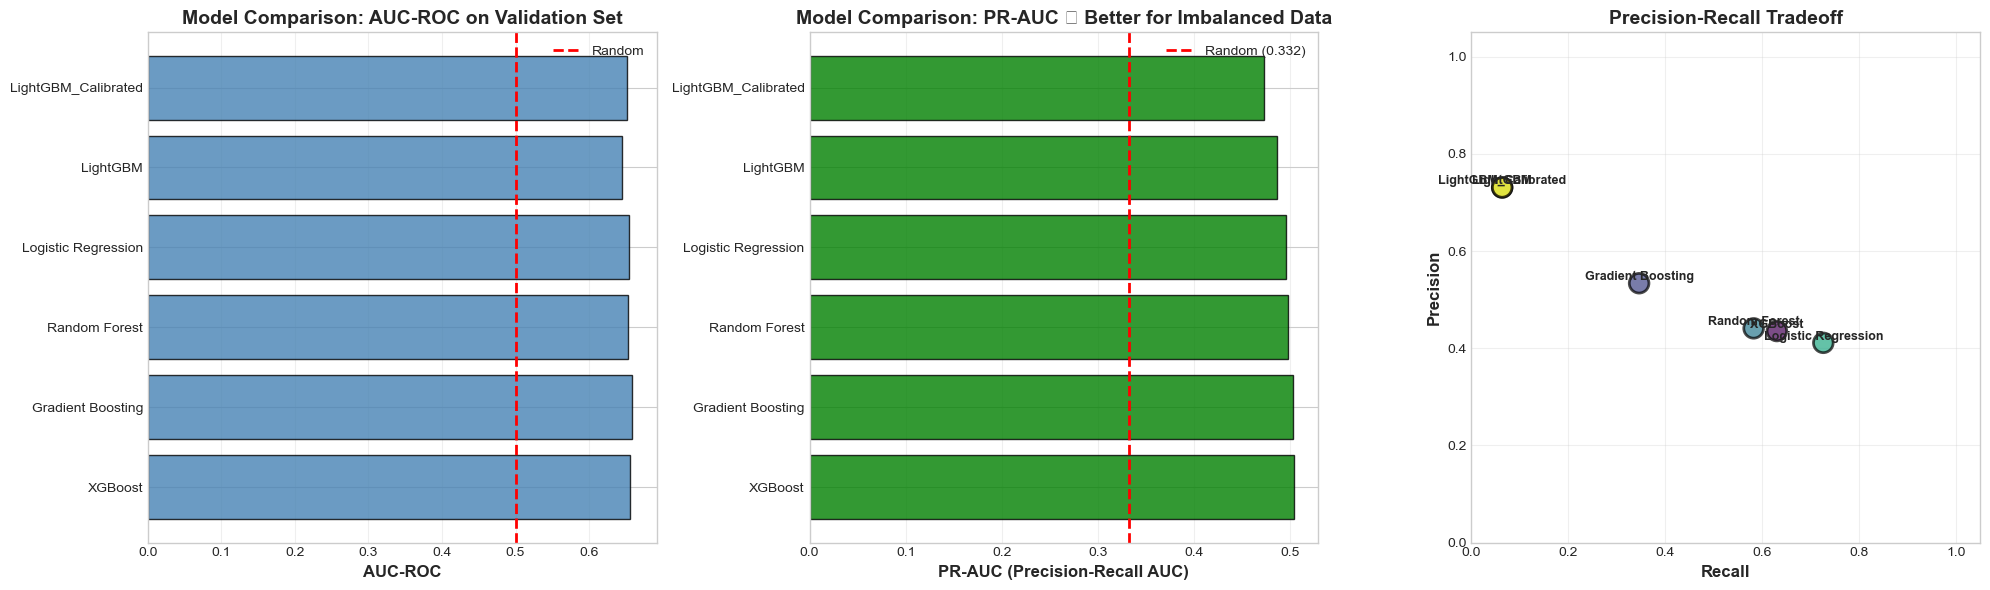

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

print("="*80)
print("TRAINING MULTIPLE LATE DELIVERY RISK PREDICTION MODELS")
print("="*80)

print(f"\nClass distribution:")
print(f"  Training:")
print(f"    Late (1): {y_train_class.sum():,} ({y_train_class.mean()*100:.2f}%)")
print(f"    On-time (0): {(~y_train_class.astype(bool)).sum():,} ({(1-y_train_class.mean())*100:.2f}%)")
print(f"  Validation:")
print(f"    Late (1): {y_val_class.sum():,} ({y_val_class.mean()*100:.2f}%)")
print(f"    On-time (0): {(~y_val_class.astype(bool)).sum():,} ({(1-y_val_class.mean())*100:.2f}%)")

models = {}
model_scores = []

print(f"\n{'='*60}")
print("1. LOGISTIC REGRESSION (Baseline)")
print('='*60)
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train_class)
lr_val_prob = lr_model.predict_proba(X_val)[:, 1]
lr_val_pred = lr_model.predict(X_val)

from sklearn.metrics import average_precision_score

lr_auc = roc_auc_score(y_val_class, lr_val_prob)
lr_pr_auc = average_precision_score(y_val_class, lr_val_prob)
lr_acc = accuracy_score(y_val_class, lr_val_pred)
lr_prec = precision_score(y_val_class, lr_val_pred, zero_division=0)
lr_rec = recall_score(y_val_class, lr_val_pred)
lr_f1 = f1_score(y_val_class, lr_val_pred)

print(f"  Validation AUC: {lr_auc:.4f}")
print(f"  Validation PR-AUC: {lr_pr_auc:.4f}")
print(f"  Validation Accuracy: {lr_acc:.4f}")
print(f"  Validation Precision: {lr_prec:.4f}")
print(f"  Validation Recall: {lr_rec:.4f}")
print(f"  Validation F1: {lr_f1:.4f}")

models['Logistic Regression'] = lr_model
model_scores.append({
    'Model': 'Logistic Regression',
    'AUC': lr_auc, 'PR-AUC': lr_pr_auc, 'Accuracy': lr_acc, 'Precision': lr_prec, 
    'Recall': lr_rec, 'F1': lr_f1
})

print(f"\n{'='*60}")
print("2. RANDOM FOREST")
print('='*60)
rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=15, min_samples_split=50,
    class_weight='balanced', random_state=42, n_jobs=-1
)
rf_model.fit(X_train, y_train_class)
rf_val_prob = rf_model.predict_proba(X_val)[:, 1]
rf_val_pred = rf_model.predict(X_val)

rf_auc = roc_auc_score(y_val_class, rf_val_prob)
rf_pr_auc = average_precision_score(y_val_class, rf_val_prob)
rf_acc = accuracy_score(y_val_class, rf_val_pred)
rf_prec = precision_score(y_val_class, rf_val_pred, zero_division=0)
rf_rec = recall_score(y_val_class, rf_val_pred)
rf_f1 = f1_score(y_val_class, rf_val_pred)

print(f"  Validation AUC: {rf_auc:.4f}")
print(f"  Validation PR-AUC: {rf_pr_auc:.4f}")
print(f"  Validation Accuracy: {rf_acc:.4f}")
print(f"  Validation Precision: {rf_prec:.4f}")
print(f"  Validation Recall: {rf_rec:.4f}")
print(f"  Validation F1: {rf_f1:.4f}")

models['Random Forest'] = rf_model
model_scores.append({
    'Model': 'Random Forest',
    'AUC': rf_auc, 'PR-AUC': rf_pr_auc, 'Accuracy': rf_acc, 'Precision': rf_prec,
    'Recall': rf_rec, 'F1': rf_f1
})

print(f"\n{'='*60}")
print("3. LIGHTGBM (Optimized)")
print('='*60)

pos = y_train_class.sum()
neg = len(y_train_class) - pos
scale_pos_weight = neg / pos

print(f"  Class balance ratio (scale_pos_weight): {scale_pos_weight:.2f}")

train_data = lgb.Dataset(X_train, label=y_train_class)
val_data = lgb.Dataset(X_val, label=y_val_class, reference=train_data)

lgb_params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": ["auc", "binary_logloss"],
    "scale_pos_weight": scale_pos_weight,
    "num_leaves": 127,
    "max_depth": -1,
    "min_data_in_leaf": 50,
    "min_gain_to_split": 0.0,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l1": 0.0,
    "lambda_l2": 5.0,
    "learning_rate": 0.03,
    "seed": 42,
    "verbose": -1,
}

lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=5000,
valid_sets=[train_data, val_data],
    valid_names=["train", "val"],
    callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
)

lgb_val_prob = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
lgb_val_pred = (lgb_val_prob >= 0.5).astype(int)

lgb_auc = roc_auc_score(y_val_class, lgb_val_prob)
lgb_pr_auc = average_precision_score(y_val_class, lgb_val_prob)
lgb_acc = accuracy_score(y_val_class, lgb_val_pred)
lgb_prec = precision_score(y_val_class, lgb_val_pred, zero_division=0)
lgb_rec = recall_score(y_val_class, lgb_val_pred)
lgb_f1 = f1_score(y_val_class, lgb_val_pred)

print(f"\n  Training completed:")
print(f"    Best iteration: {lgb_model.best_iteration}")
print(f"    Validation AUC-ROC: {lgb_auc:.4f}")
print(f"    Validation PR-AUC: {lgb_pr_auc:.4f}")
print(f"    Validation Accuracy: {lgb_acc:.4f}")
print(f"    Validation Precision: {lgb_prec:.4f}")
print(f"    Validation Recall: {lgb_rec:.4f}")
print(f"    Validation F1: {lgb_f1:.4f}")

models['LightGBM'] = lgb_model
model_scores.append({
    'Model': 'LightGBM',
    'AUC': lgb_auc, 'PR-AUC': lgb_pr_auc, 'Accuracy': lgb_acc, 'Precision': lgb_prec,
    'Recall': lgb_rec, 'F1': lgb_f1
})

print(f"\n  Applying probability calibration...")
from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression(out_of_bounds='clip')
iso_reg.fit(lgb_val_prob, y_val_class)

lgb_val_prob_calibrated = iso_reg.predict(lgb_val_prob)

lgb_auc_cal = roc_auc_score(y_val_class, lgb_val_prob_calibrated)
lgb_pr_auc_cal = average_precision_score(y_val_class, lgb_val_prob_calibrated)

print(f"    Calibrated AUC-ROC: {lgb_auc_cal:.4f} (Δ {lgb_auc_cal - lgb_auc:+.4f})")
print(f"    Calibrated PR-AUC: {lgb_pr_auc_cal:.4f} (Δ {lgb_pr_auc_cal - lgb_pr_auc:+.4f})")

models['LightGBM_Calibrated'] = (lgb_model, iso_reg)
model_scores.append({
    'Model': 'LightGBM_Calibrated',
    'AUC': lgb_auc_cal, 'PR-AUC': lgb_pr_auc_cal, 'Accuracy': lgb_acc, 'Precision': lgb_prec,
    'Recall': lgb_rec, 'F1': lgb_f1
})

print(f"\n{'='*60}")
print("4. XGBOOST")
print('='*60)

scale_pos_weight = (y_train_class == 0).sum() / (y_train_class == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='auc',
    early_stopping_rounds=50
)

xgb_model.fit(
    X_train, y_train_class,
    eval_set=[(X_val, y_val_class)],
    verbose=False
)

xgb_val_prob = xgb_model.predict_proba(X_val)[:, 1]
xgb_val_pred = xgb_model.predict(X_val)

xgb_auc = roc_auc_score(y_val_class, xgb_val_prob)
xgb_pr_auc = average_precision_score(y_val_class, xgb_val_prob)
xgb_acc = accuracy_score(y_val_class, xgb_val_pred)
xgb_prec = precision_score(y_val_class, xgb_val_pred, zero_division=0)
xgb_rec = recall_score(y_val_class, xgb_val_pred)
xgb_f1 = f1_score(y_val_class, xgb_val_pred)

print(f"  Best iteration: {xgb_model.best_iteration}")
print(f"  Validation AUC: {xgb_auc:.4f}")
print(f"  Validation PR-AUC: {xgb_pr_auc:.4f}")
print(f"  Validation Accuracy: {xgb_acc:.4f}")
print(f"  Validation Precision: {xgb_prec:.4f}")
print(f"  Validation Recall: {xgb_rec:.4f}")
print(f"  Validation F1: {xgb_f1:.4f}")

models['XGBoost'] = xgb_model
model_scores.append({
    'Model': 'XGBoost',
    'AUC': xgb_auc, 'PR-AUC': xgb_pr_auc, 'Accuracy': xgb_acc, 'Precision': xgb_prec,
    'Recall': xgb_rec, 'F1': xgb_f1
})

print(f"\n{'='*60}")
print("5. GRADIENT BOOSTING")
print('='*60)
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train, y_train_class)
gb_val_prob = gb_model.predict_proba(X_val)[:, 1]
gb_val_pred = gb_model.predict(X_val)

gb_auc = roc_auc_score(y_val_class, gb_val_prob)
gb_pr_auc = average_precision_score(y_val_class, gb_val_prob)
gb_acc = accuracy_score(y_val_class, gb_val_pred)
gb_prec = precision_score(y_val_class, gb_val_pred, zero_division=0)
gb_rec = recall_score(y_val_class, gb_val_pred)
gb_f1 = f1_score(y_val_class, gb_val_pred)

print(f"  Validation AUC: {gb_auc:.4f}")
print(f"  Validation PR-AUC: {gb_pr_auc:.4f}")
print(f"  Validation Accuracy: {gb_acc:.4f}")
print(f"  Validation Precision: {gb_prec:.4f}")
print(f"  Validation Recall: {gb_rec:.4f}")
print(f"  Validation F1: {gb_f1:.4f}")

models['Gradient Boosting'] = gb_model
model_scores.append({
    'Model': 'Gradient Boosting',
    'AUC': gb_auc, 'PR-AUC': gb_pr_auc, 'Accuracy': gb_acc, 'Precision': gb_prec,
    'Recall': gb_rec, 'F1': gb_f1
})

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame(model_scores).sort_values('PR-AUC', ascending=False)
print("\nModel Performance on Validation Set (sorted by PR-AUC):")
print(comparison_df.to_string(index=False))

comparison_df.to_csv(os.path.join(MODEL_OUTPUT_DIR, 'model_comparison.csv'), index=False)
print(f"\nSaved model comparison to {MODEL_OUTPUT_DIR}/model_comparison.csv")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax1 = axes[0]
x_pos = np.arange(len(comparison_df))
ax1.barh(x_pos, comparison_df['AUC'].values, alpha=0.7, edgecolor='black')
ax1.set_yticks(x_pos)
ax1.set_yticklabels(comparison_df['Model'].values)
ax1.set_xlabel('AUC-ROC', fontsize=12, fontweight='bold')
ax1.set_title('Model Comparison: AUC-ROC', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['AUC'].values):
    ax1.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10)

ax2 = axes[1]
ax2.barh(x_pos, comparison_df['PR-AUC'].values, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_yticks(x_pos)
ax2.set_yticklabels(comparison_df['Model'].values)
ax2.set_xlabel('PR-AUC', fontsize=12, fontweight='bold')
ax2.set_title('Model Comparison: PR-AUC (Better for Imbalanced)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['PR-AUC'].values):
    ax2.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
save_figure('model_comparison.png')
plt.show()

best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBest model by PR-AUC: {best_model_name}")

## 6. Analyze Probability Distributions and Select Optimal Threshold

ANALYZING PROBABILITY DISTRIBUTIONS

Probability Statistics (Validation):
  On-time deliveries (class=0):
    Mean prob: 0.4773
    Median prob: 0.4687
    Max prob: 0.9479
  Late deliveries (class=1):
    Mean prob: 0.5574
    Median prob: 0.5534
    Max prob: 0.9493

Probability Statistics (Test):
  On-time deliveries (class=0):
    Mean prob: 0.4746
    Median prob: 0.4680
  Late deliveries (class=1):
    Mean prob: 0.5583
    Median prob: 0.5514

FINDING OPTIMAL THRESHOLD

Optimal threshold (balanced): 0.5795
F1-Score at optimal threshold: 0.4682
Precision at optimal threshold: 0.5005
Recall at optimal threshold: 0.4399

💡 Strategy: Selected threshold with precision >= 0.50 to reduce false positives

Threshold Comparison (Validation Set):
 Threshold  Accuracy  Precision  Recall     F1
    0.2000    0.3374     0.3336  0.9975 0.5000
    0.2500    0.3486     0.3365  0.9891 0.5021
    0.3000    0.3715     0.3415  0.9613 0.5040
    0.5795    0.6682     0.5005  0.4399 0.4682
    0.4000  

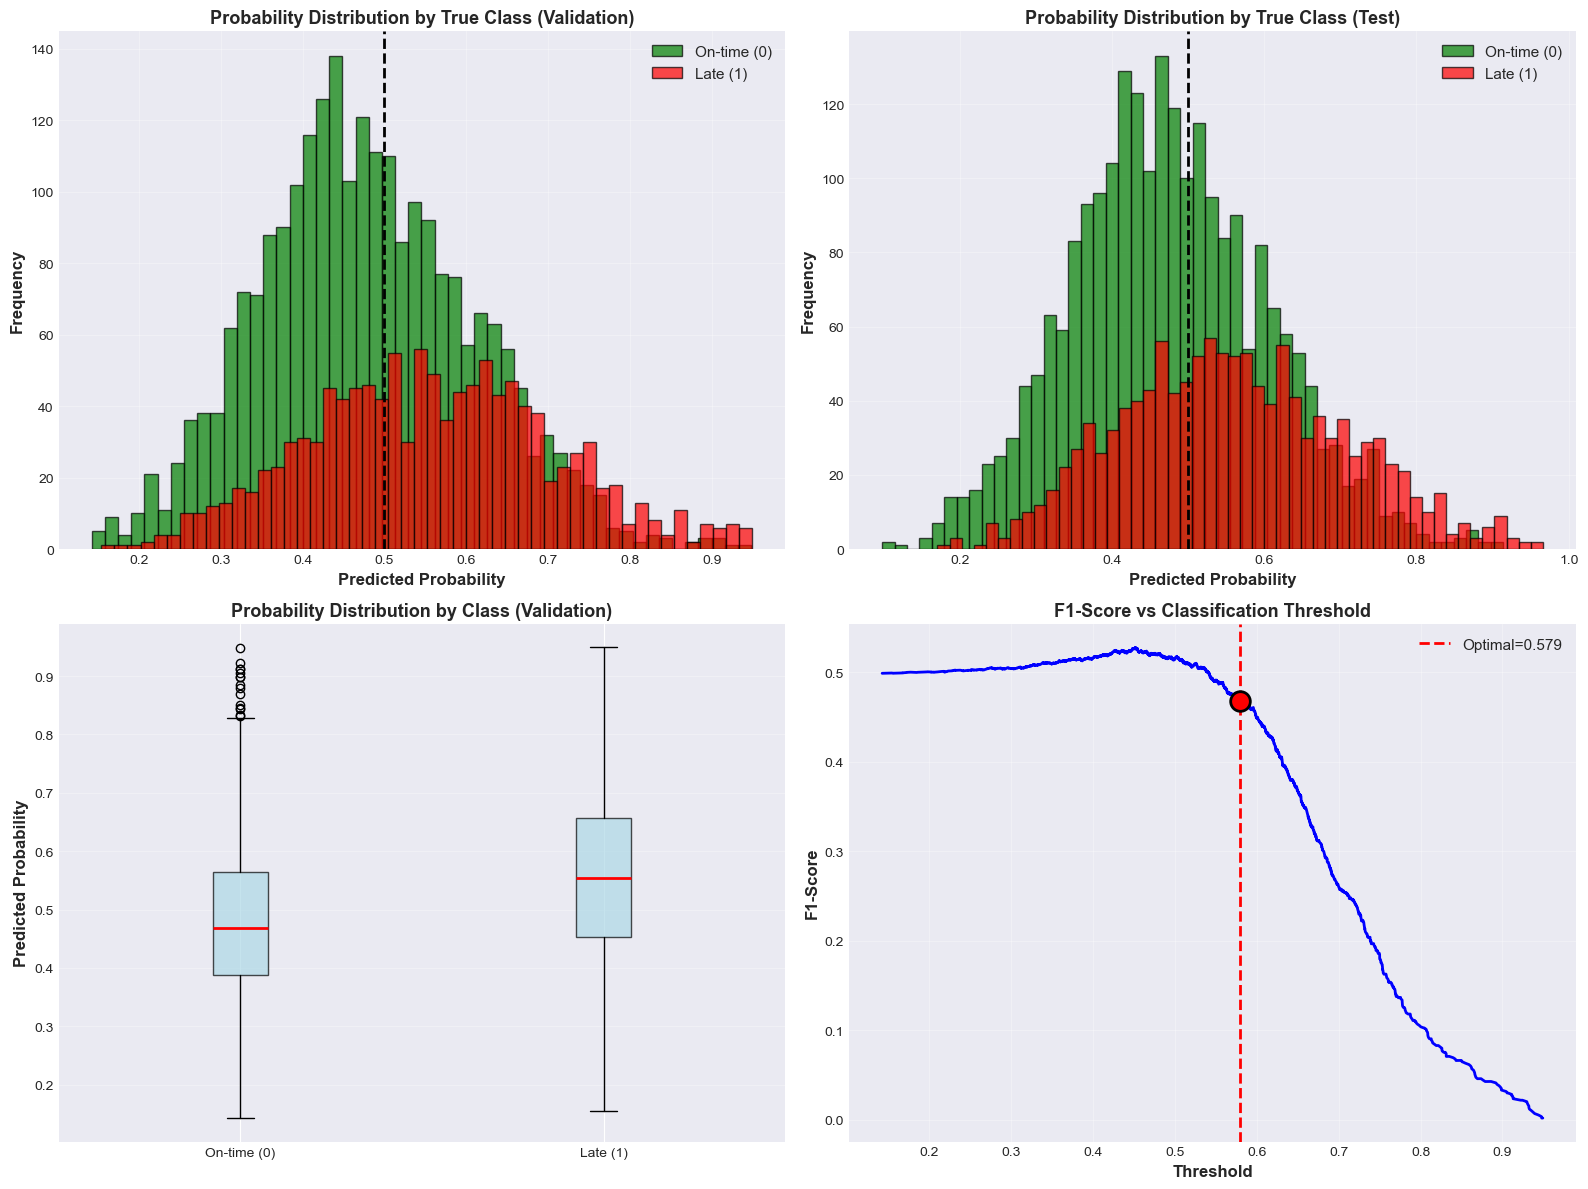


✅ Using optimal threshold: 0.5795


In [56]:
print("="*80)
print("ANALYZING PROBABILITY DISTRIBUTIONS")
print("="*80)

# Analyze prediction probability distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Validation set probability distribution by true class
axes[0, 0].hist(y_val_prob[y_val_class == 0], bins=50, alpha=0.7, label='On-time (0)', color='green', edgecolor='black')
axes[0, 0].hist(y_val_prob[y_val_class == 1], bins=50, alpha=0.7, label='Late (1)', color='red', edgecolor='black')
axes[0, 0].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Probability Distribution by True Class (Validation)', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[0, 0].grid(True, alpha=0.3)

# Test set probability distribution by true class
axes[0, 1].hist(y_test_prob[y_test_class == 0], bins=50, alpha=0.7, label='On-time (0)', color='green', edgecolor='black')
axes[0, 1].hist(y_test_prob[y_test_class == 1], bins=50, alpha=0.7, label='Late (1)', color='red', edgecolor='black')
axes[0, 1].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Probability Distribution by True Class (Test)', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].axvline(0.5, color='black', linestyle='--', linewidth=2)
axes[0, 1].grid(True, alpha=0.3)

# Boxplot of probabilities by true class (Validation)
axes[1, 0].boxplot([y_val_prob[y_val_class == 0], y_val_prob[y_val_class == 1]],
                    labels=['On-time (0)', 'Late (1)'],
                    patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
axes[1, 0].set_ylabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Probability Distribution by Class (Validation)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Probability statistics
print(f"\nProbability Statistics (Validation):")
print(f"  On-time deliveries (class=0):")
print(f"    Mean prob: {y_val_prob[y_val_class == 0].mean():.4f}")
print(f"    Median prob: {np.median(y_val_prob[y_val_class == 0]):.4f}")
print(f"    Max prob: {y_val_prob[y_val_class == 0].max():.4f}")
print(f"  Late deliveries (class=1):")
print(f"    Mean prob: {y_val_prob[y_val_class == 1].mean():.4f}")
print(f"    Median prob: {np.median(y_val_prob[y_val_class == 1]):.4f}")
print(f"    Max prob: {y_val_prob[y_val_class == 1].max():.4f}")

print(f"\nProbability Statistics (Test):")
print(f"  On-time deliveries (class=0):")
print(f"    Mean prob: {y_test_prob[y_test_class == 0].mean():.4f}")
print(f"    Median prob: {np.median(y_test_prob[y_test_class == 0]):.4f}")
print(f"  Late deliveries (class=1):")
print(f"    Mean prob: {y_test_prob[y_test_class == 1].mean():.4f}")
print(f"    Median prob: {np.median(y_test_prob[y_test_class == 1]):.4f}")

# Find optimal threshold using validation set
print(f"\n{'='*80}")
print("FINDING OPTIMAL THRESHOLD")
print('='*80)

from sklearn.metrics import precision_recall_curve

precision_vals, recall_vals, thresholds = precision_recall_curve(y_val_class, y_val_prob)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)

# Find threshold that balances precision and recall (less aggressive)
# We want precision >= 0.50 to avoid too many false positives
valid_thresholds = np.where(precision_vals[:-1] >= 0.50)[0]
if len(valid_thresholds) > 0:
    # Among thresholds with precision >= 0.50, pick the one with best F1
    optimal_idx = valid_thresholds[np.argmax(f1_scores[valid_thresholds])]
else:
    # Fallback: maximize F1 but warn about low precision
    optimal_idx = np.argmax(f1_scores[:-1])
    print("⚠️  Warning: Could not find threshold with precision >= 0.50")

optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"\nOptimal threshold (balanced): {optimal_threshold:.4f}")
print(f"F1-Score at optimal threshold: {optimal_f1:.4f}")
print(f"Precision at optimal threshold: {precision_vals[optimal_idx]:.4f}")
print(f"Recall at optimal threshold: {recall_vals[optimal_idx]:.4f}")
print(f"\n💡 Strategy: Selected threshold with precision >= 0.50 to reduce false positives")

# Test multiple thresholds
test_thresholds = [0.2, 0.25, 0.3, optimal_threshold, 0.4, 0.45, 0.5]
threshold_results = []

for thresh in test_thresholds:
    y_pred = (y_val_prob >= thresh).astype(int)
    acc = accuracy_score(y_val_class, y_pred)
    prec = precision_score(y_val_class, y_pred, zero_division=0)
    rec = recall_score(y_val_class, y_pred)
    f1 = f1_score(y_val_class, y_pred)
    
    threshold_results.append({
        'Threshold': thresh,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    })

thresh_df = pd.DataFrame(threshold_results)
print(f"\nThreshold Comparison (Validation Set):")
print(thresh_df.to_string(index=False))

# Plot F1 vs threshold
axes[1, 1].plot(thresholds, f1_scores[:-1], linewidth=2, color='blue')
axes[1, 1].axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'Optimal={optimal_threshold:.3f}')
axes[1, 1].scatter([optimal_threshold], [optimal_f1], color='red', s=200, zorder=5, edgecolor='black', linewidth=2)
axes[1, 1].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('F1-Score vs Classification Threshold', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
save_figure('probability_analysis_and_threshold.png')
plt.show()

print(f"\n✅ Using optimal threshold: {optimal_threshold:.4f}")

## 7. Detailed Test Set Evaluation: Late Delivery Prediction Performance

TEST SET EVALUATION: HOW WELL DID WE PREDICT LATE DELIVERIES?

📊 GROUND TRUTH ANALYSIS (Test Set):
  Total orders: 3,580
  Actual > Upper Estimate (Late): 1,246 (34.80%)
  Actual <= Upper Estimate (On-time): 2,334 (65.20%)

  Late orders statistics:
    Mean overage: 9.65 minutes
    Median overage: 6.74 minutes
    Max overage: 133.27 minutes

🎯 MODEL PREDICTIONS (Test Set, Threshold=0.5795):
  Predicted Late: 1,010 (28.21%)
  Predicted On-time: 2,570 (71.79%)

📈 CLASSIFICATION METRICS (Test Set):
  AUC-ROC: 0.6621
  Average Precision: 0.5287
  Accuracy: 0.6637
  Precision: 0.5208 (Of predicted late, 52.1% were actually late)
  Recall: 0.4222 (Caught 42.2% of all late deliveries)
  F1-Score: 0.4663

📊 CONFUSION MATRIX (Test Set):
                    Predicted
                On-time    Late
  Actual On-time     1850     484
  Actual Late         720     526

  True Negatives (TN): 1,850 - Correctly predicted on-time
  False Positives (FP): 484 - Wrongly predicted late (over-correction

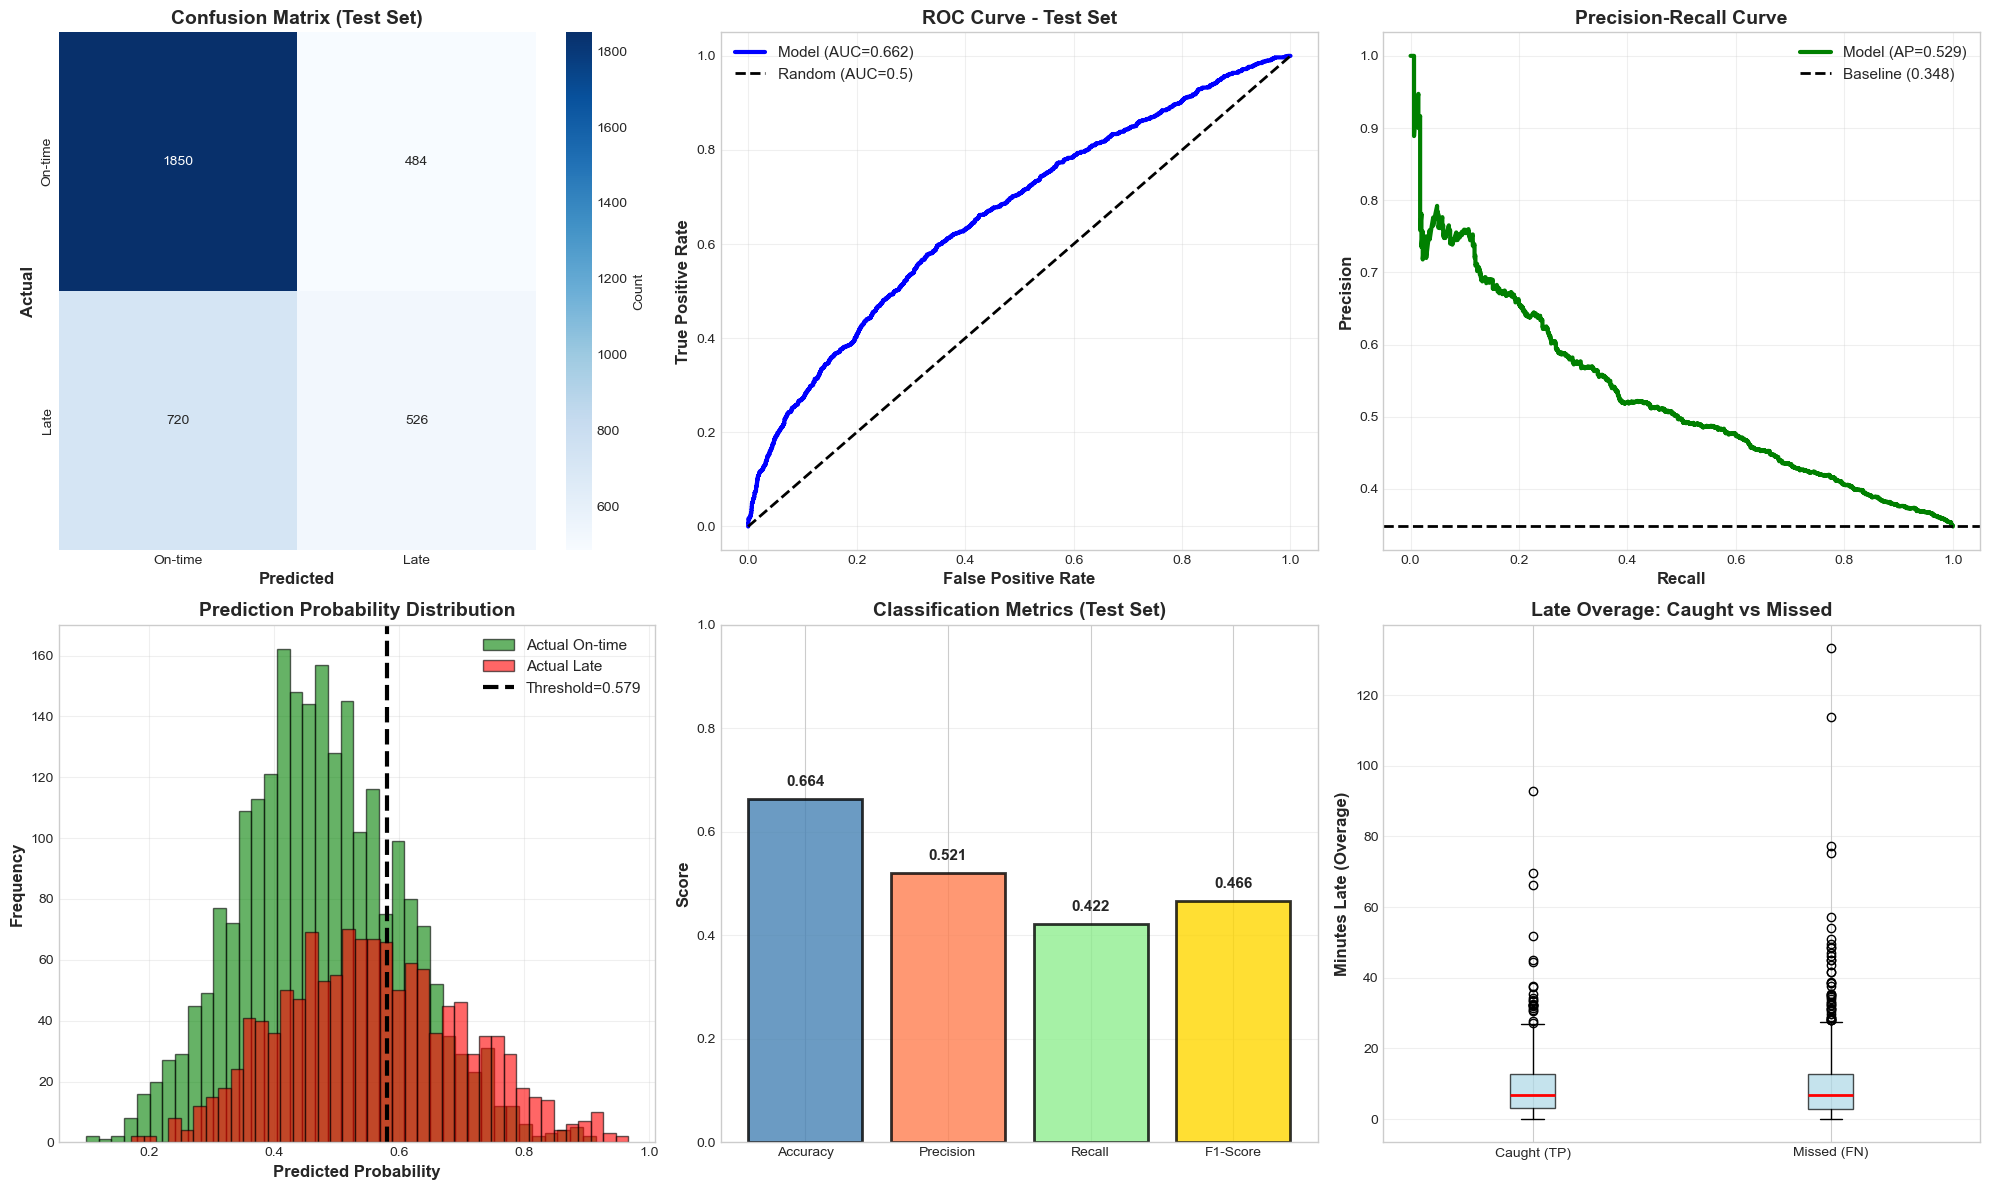


✅ Test set evaluation complete!


In [65]:
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, 
                             precision_recall_curve, average_precision_score)

print("="*80)
print("TEST SET EVALUATION: HOW WELL DID WE PREDICT LATE DELIVERIES?")
print("="*80)

# First, let's verify the ground truth
print(f"\n📊 GROUND TRUTH ANALYSIS (Test Set):")
print(f"  Total orders: {len(test_df):,}")
print(f"  Actual > Upper Estimate (Late): {y_test_class.sum():,} ({y_test_class.mean()*100:.2f}%)")
print(f"  Actual <= Upper Estimate (On-time): {(~y_test_class.astype(bool)).sum():,} ({(1-y_test_class.mean())*100:.2f}%)")

# Statistics of how late they were
late_orders_mask = y_test_class == 1
late_overage = test_df.loc[late_orders_mask, 'actual_delivery_time_minutes'].values - test_df.loc[late_orders_mask, 'estimated_delivery_time_upper_minutes'].values

print(f"\n  Late orders statistics:")
print(f"    Mean overage: {late_overage.mean():.2f} minutes")
print(f"    Median overage: {np.median(late_overage):.2f} minutes")
print(f"    Max overage: {late_overage.max():.2f} minutes")

# Make predictions at optimal threshold
y_test_pred = (y_test_prob >= optimal_threshold).astype(int)

print(f"\n🎯 MODEL PREDICTIONS (Test Set, Threshold={optimal_threshold:.4f}):")
print(f"  Predicted Late: {y_test_pred.sum():,} ({y_test_pred.mean()*100:.2f}%)")
print(f"  Predicted On-time: {(~y_test_pred.astype(bool)).sum():,} ({(1-y_test_pred.mean())*100:.2f}%)")

# Classification metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

test_auc = roc_auc_score(y_test_class, y_test_prob)
test_ap = average_precision_score(y_test_class, y_test_prob)
test_acc = accuracy_score(y_test_class, y_test_pred)
test_prec = precision_score(y_test_class, y_test_pred, zero_division=0)
test_rec = recall_score(y_test_class, y_test_pred)
test_f1 = f1_score(y_test_class, y_test_pred)

print(f"\n📈 CLASSIFICATION METRICS (Test Set):")
print(f"  AUC-ROC: {test_auc:.4f}")
print(f"  Average Precision: {test_ap:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f} (Of predicted late, {test_prec*100:.1f}% were actually late)")
print(f"  Recall: {test_rec:.4f} (Caught {test_rec*100:.1f}% of all late deliveries)")
print(f"  F1-Score: {test_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test_class, y_test_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n📊 CONFUSION MATRIX (Test Set):")
print(f"                    Predicted")
print(f"                On-time    Late")
print(f"  Actual On-time    {tn:5d}   {fp:5d}")
print(f"  Actual Late       {fn:5d}   {tp:5d}")
print(f"\n  True Negatives (TN): {tn:,} - Correctly predicted on-time")
print(f"  False Positives (FP): {fp:,} - Wrongly predicted late (over-correction)")
print(f"  False Negatives (FN): {fn:,} - Missed late deliveries")
print(f"  True Positives (TP): {tp:,} - Correctly predicted late")

# Detailed classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test_class, y_test_pred, 
                           target_names=['On-time (0)', 'Late (1)'],
                           digits=4))

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['On-time', 'Late'],
            yticklabels=['On-time', 'Late'],
            ax=axes[0, 0], cbar_kws={'label': 'Count'})
axes[0, 0].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test_class, y_test_prob)
axes[0, 1].plot(fpr, tpr, linewidth=3, label=f'Model (AUC={test_auc:.3f})', color='blue')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC=0.5)')
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 1].set_title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_class, y_test_prob)
axes[0, 2].plot(recall, precision, linewidth=3, label=f'Model (AP={test_ap:.3f})', color='green')
baseline = y_test_class.mean()
axes[0, 2].axhline(baseline, color='k', linestyle='--', linewidth=2, label=f'Baseline ({baseline:.3f})')
axes[0, 2].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[0, 2].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0, 2].legend(fontsize=11)
axes[0, 2].grid(True, alpha=0.3)

# 4. Probability distribution with predictions
axes[1, 0].hist(y_test_prob[y_test_class == 0], bins=40, alpha=0.6, label='Actual On-time', color='green', edgecolor='black')
axes[1, 0].hist(y_test_prob[y_test_class == 1], bins=40, alpha=0.6, label='Actual Late', color='red', edgecolor='black')
axes[1, 0].axvline(optimal_threshold, color='black', linestyle='--', linewidth=3, label=f'Threshold={optimal_threshold:.3f}')
axes[1, 0].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# 5. Performance metrics bar chart
metrics_data = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [test_acc, test_prec, test_rec, test_f1]
colors_bar = ['steelblue', 'coral', 'lightgreen', 'gold']

axes[1, 1].bar(metrics_data, metrics_values, alpha=0.8, edgecolor='black', color=colors_bar, linewidth=2)
axes[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Classification Metrics (Test Set)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(metrics_values):
    axes[1, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 6. Late delivery overage by correct/incorrect predictions
correct_late_pred = (y_test_class == 1) & (y_test_pred == 1)  # TP
missed_late_pred = (y_test_class == 1) & (y_test_pred == 0)  # FN

overage_correct = test_df.loc[correct_late_pred, 'actual_delivery_time_minutes'].values - \
                  test_df.loc[correct_late_pred, 'estimated_delivery_time_upper_minutes'].values
overage_missed = test_df.loc[missed_late_pred, 'actual_delivery_time_minutes'].values - \
                 test_df.loc[missed_late_pred, 'estimated_delivery_time_upper_minutes'].values

axes[1, 2].boxplot([overage_correct, overage_missed],
                    labels=['Caught (TP)', 'Missed (FN)'],
                    patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
axes[1, 2].set_ylabel('Minutes Late (Overage)', fontsize=12, fontweight='bold')
axes[1, 2].set_title('Late Overage: Caught vs Missed', fontsize=14, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

print(f"\n  Overage for correctly predicted late (TP): {overage_correct.mean():.2f} min (median: {np.median(overage_correct):.2f})")
print(f"  Overage for missed late (FN): {overage_missed.mean():.2f} min (median: {np.median(overage_missed):.2f})")

plt.tight_layout()
save_figure('test_set_detailed_evaluation.png')
plt.show()

print(f"\n✅ Test set evaluation complete!")

## 8. Apply Risk-Based ETA Corrections to Test Set

APPLYING RISK-BASED ETA CORRECTIONS TO TEST SET

🔧 Correction Strategy:
  • Threshold: 0.5795
  • If predicted late probability >= 0.5795: Add venue buffer
  • Venue-specific buffers: 113 venues
  • Global fallback buffer: 3.93 minutes

📊 Corrections Applied (Test Set):
  Orders receiving corrections: 1,010 / 3,580 (28.21%)
  Orders no correction: 2,570 (71.79%)
  Average buffer (when applied): 4.25 minutes
  Median buffer (when applied): 4.18 minutes
  Buffer range: [0.23, 43.21] minutes
✓ Saved figure: correction_application_analysis.png


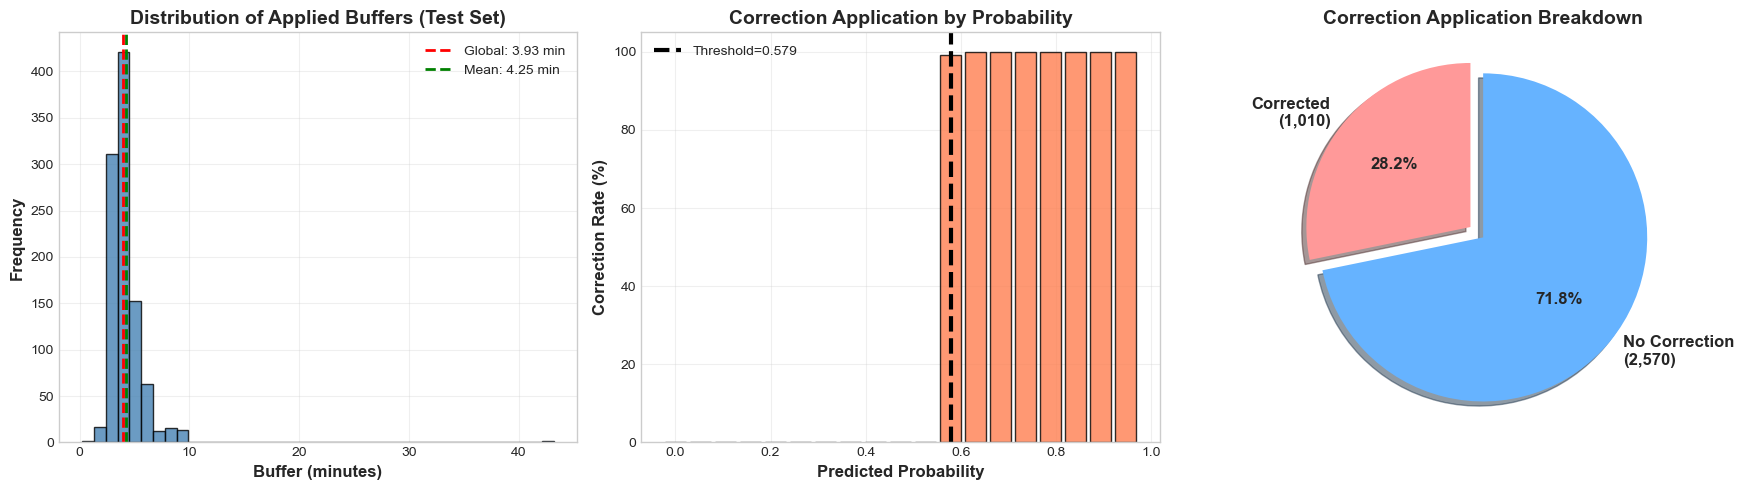


✅ Corrections applied to test set!


In [66]:
def apply_corrections(df, late_prob, venue_buffers, global_buffer, threshold):
    """
    Apply venue-specific ETA corrections based on late delivery risk.
    
    Args:
        df: DataFrame with estimated_upper and venue_location_h3_index
        late_prob: Predicted late delivery probabilities
        venue_buffers: Dict of venue-specific buffers
        global_buffer: Global fallback buffer
        threshold: Probability threshold for applying correction
        
    Returns:
        corrected_upper: Corrected upper estimate
        applied_buffer: Buffer applied to each order
        correction_applied: Boolean mask of where correction was applied
    """
    df_copy = df.copy()
    n = len(df_copy)
    
    # Initialize
    corrected_upper = df_copy['estimated_delivery_time_upper_minutes'].values.copy()
    applied_buffer = np.zeros(n)
    correction_applied = np.zeros(n, dtype=bool)
    
    # Apply correction where late_prob exceeds threshold
    for i in range(n):
        if late_prob[i] >= threshold:
            venue_id = df_copy.iloc[i]['venue_location_h3_index']
            
            # Get venue-specific buffer or use global fallback
            buffer = venue_buffers.get(venue_id, global_buffer)
            if pd.isna(buffer):
                buffer = global_buffer
            
            # Apply correction
            corrected_upper[i] += buffer
            applied_buffer[i] = buffer
            correction_applied[i] = True
    
    return corrected_upper, applied_buffer, correction_applied

print("="*80)
print("APPLYING RISK-BASED ETA CORRECTIONS TO TEST SET")
print("="*80)

print(f"\n🔧 Correction Strategy:")
print(f"  • Threshold: {optimal_threshold:.4f}")
print(f"  • If predicted late probability >= {optimal_threshold:.4f}: Add venue buffer")
print(f"  • Venue-specific buffers: {venue_buffer_stats['buffer_minutes'].notna().sum():,} venues")
print(f"  • Global fallback buffer: {global_buffer:.2f} minutes")

# Apply corrections to test set
test_corrected, test_buffers, test_applied = apply_corrections(
    test_df, y_test_prob, venue_buffers, global_buffer, threshold=optimal_threshold)

print(f"\n📊 Corrections Applied (Test Set):")
print(f"  Orders receiving corrections: {test_applied.sum():,} / {len(test_df):,} ({test_applied.mean()*100:.2f}%)")
print(f"  Orders no correction: {(~test_applied).sum():,} ({(~test_applied).mean()*100:.2f}%)")
print(f"  Average buffer (when applied): {test_buffers[test_applied].mean():.2f} minutes")
print(f"  Median buffer (when applied): {np.median(test_buffers[test_applied]):.2f} minutes")
print(f"  Buffer range: [{test_buffers[test_applied].min():.2f}, {test_buffers[test_applied].max():.2f}] minutes")

# Visualize buffer application
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Buffer distribution
axes[0].hist(test_buffers[test_applied], bins=40, alpha=0.8, edgecolor='black', color='steelblue')
axes[0].axvline(global_buffer, color='red', linestyle='--', linewidth=2, label=f'Global: {global_buffer:.2f} min')
axes[0].axvline(test_buffers[test_applied].mean(), color='green', linestyle='--', linewidth=2, 
                label=f'Mean: {test_buffers[test_applied].mean():.2f} min')
axes[0].set_xlabel('Buffer (minutes)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Applied Buffers (Test Set)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Correction by predicted probability
prob_bins = np.linspace(0, 1, 20)
correction_rate_by_prob = []
for i in range(len(prob_bins)-1):
    mask = (y_test_prob >= prob_bins[i]) & (y_test_prob < prob_bins[i+1])
    if mask.sum() > 0:
        correction_rate_by_prob.append(test_applied[mask].mean() * 100)
    else:
        correction_rate_by_prob.append(0)

axes[1].bar(prob_bins[:-1], correction_rate_by_prob, width=0.045, alpha=0.8, edgecolor='black', color='coral')
axes[1].axvline(optimal_threshold, color='black', linestyle='--', linewidth=3, label=f'Threshold={optimal_threshold:.3f}')
axes[1].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Correction Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Correction Application by Probability', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Pie chart: correction breakdown
correction_labels = [f'Corrected\n({test_applied.sum():,})', f'No Correction\n({(~test_applied).sum():,})']
correction_sizes = [test_applied.sum(), (~test_applied).sum()]
correction_colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)

axes[2].pie(correction_sizes, explode=explode, labels=correction_labels, colors=correction_colors,
            autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[2].set_title('Correction Application Breakdown', fontsize=14, fontweight='bold')

plt.tight_layout()
save_figure('correction_application_analysis.png')
plt.show()

print(f"\n✅ Corrections applied to test set!")

## 9. Comprehensive Before vs After Correction Evaluation (Test Set)

COMPREHENSIVE BEFORE VS AFTER CORRECTION ANALYSIS (TEST SET)

📊 ETA ACCURACY METRICS:

Mean Absolute Error (MAE):
  Before correction: 9.29 minutes
  After correction:  9.44 minutes
  Improvement: -0.14 minutes (+1.5%)

Root Mean Squared Error (RMSE):
  Before correction: 12.34 minutes
  After correction:  12.27 minutes
  Improvement: +0.07 minutes (-0.6%)

🎯 LATE DELIVERY RATE (Actual > Estimate):
  Before correction: 34.80%
  After correction:  30.39%
  Reduction: 4.41 pp (12.7% relative reduction)

✅ ON-TIME DELIVERY RATE (Actual <= Estimate):
  Before correction: 65.20%
  After correction:  69.61%
  Improvement: +4.41 pp

📈 IMPACT OF CORRECTIONS ON PREDICTED LATE DELIVERIES:
  Orders with correction: 1,010
  Late rate BEFORE buffer: 52.08%
  Late rate AFTER buffer:  36.44%
  Reduction: 15.64 pp
✓ Saved figure: eval_01_late_rate_improvement.png


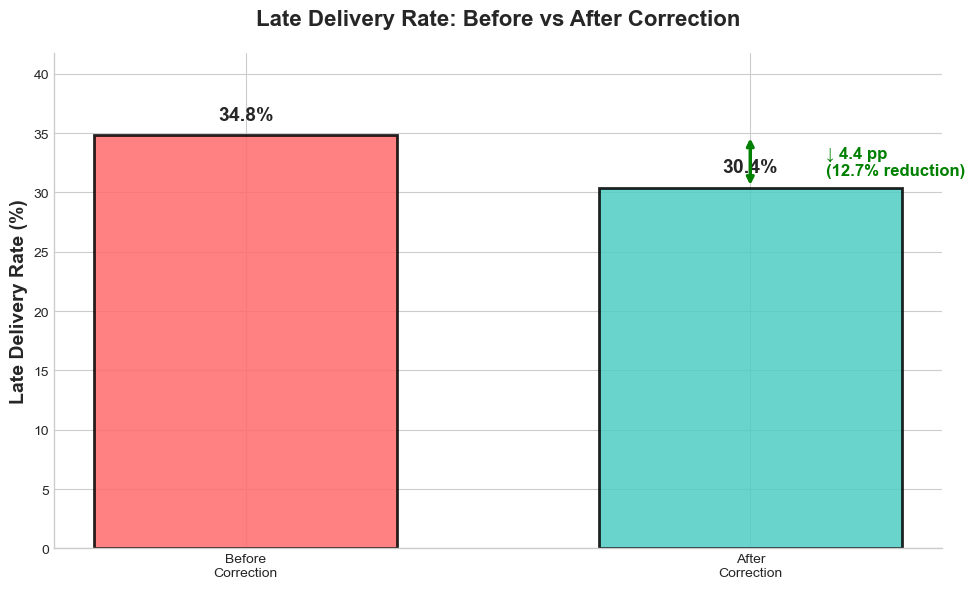

✓ Saved figure: eval_02_ontime_rate_improvement.png


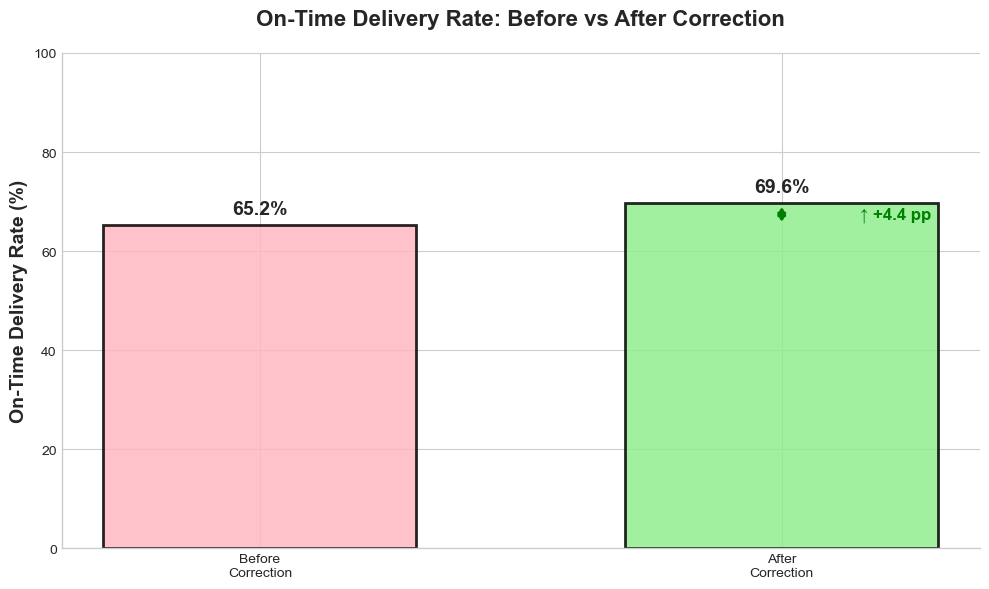

✓ Saved figure: eval_03_error_metrics_improvement.png


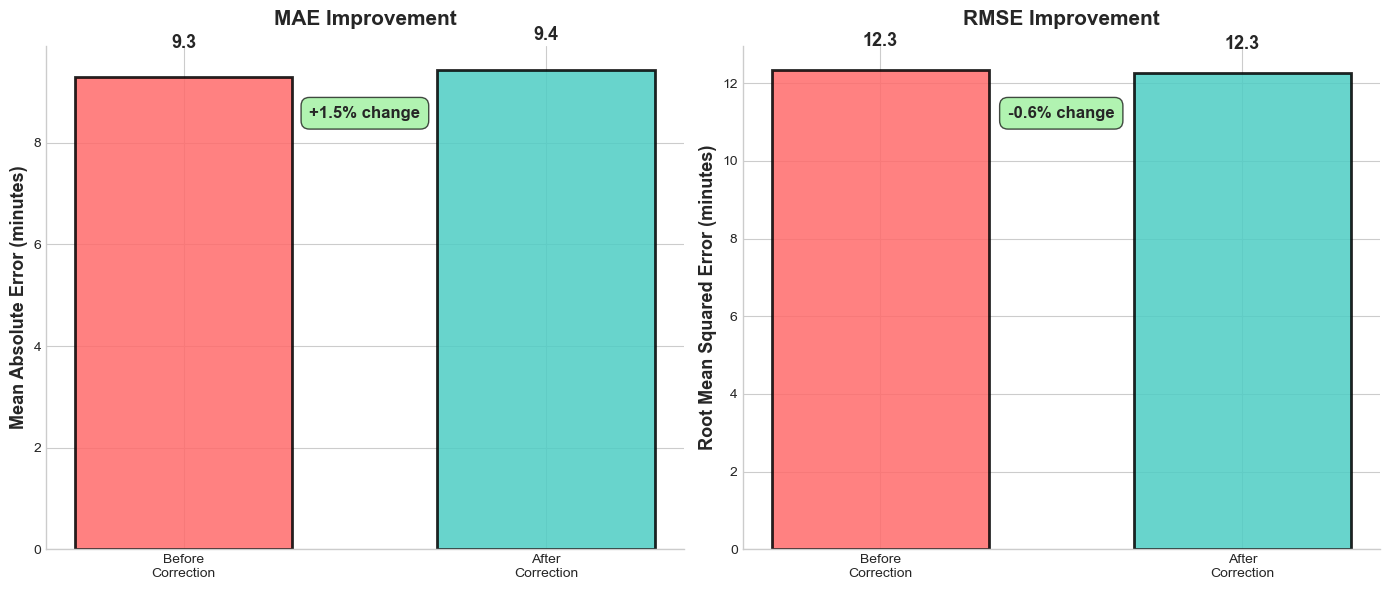

✓ Saved figure: eval_04_confusion_matrix.png


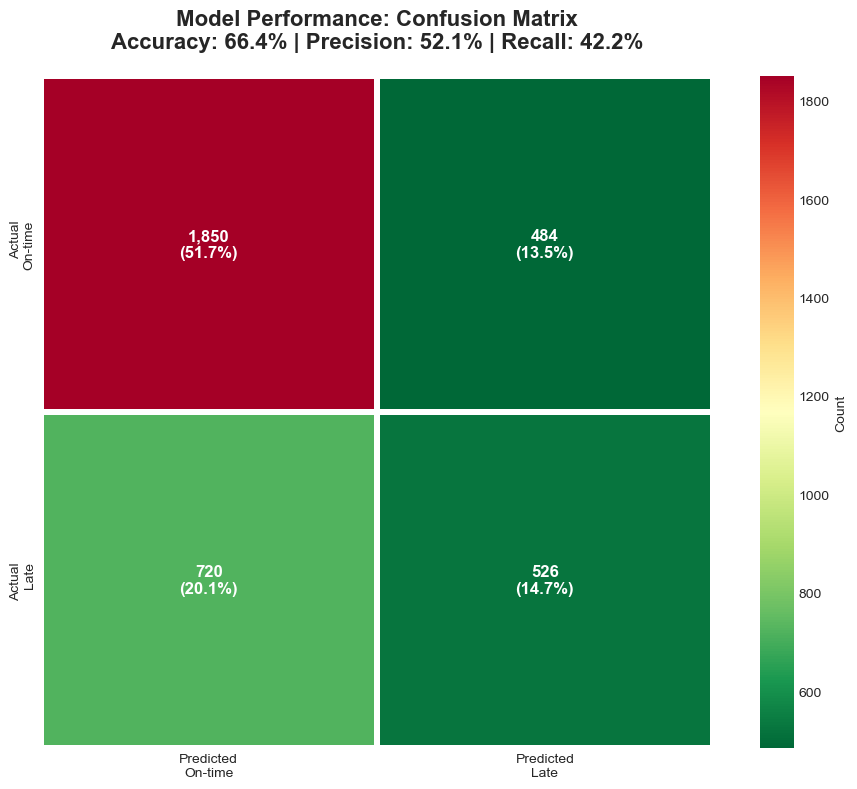

✓ Saved figure: eval_05_performance_metrics_card.png


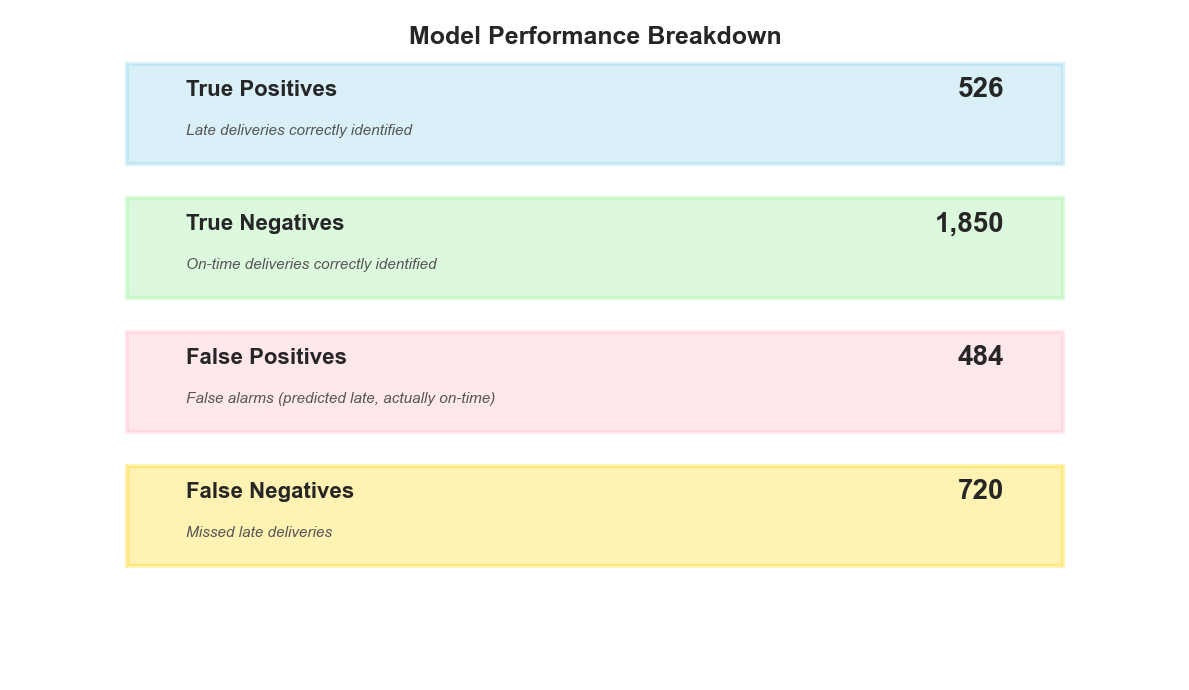

✓ Saved figure: eval_06_buffer_impact.png


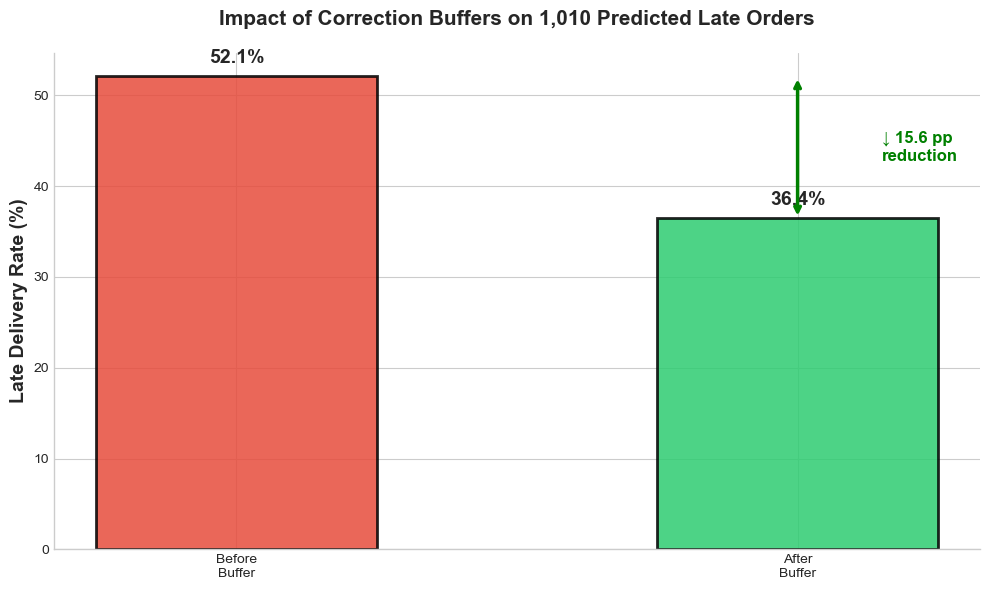

✓ Saved figure: eval_07_summary_dashboard.png


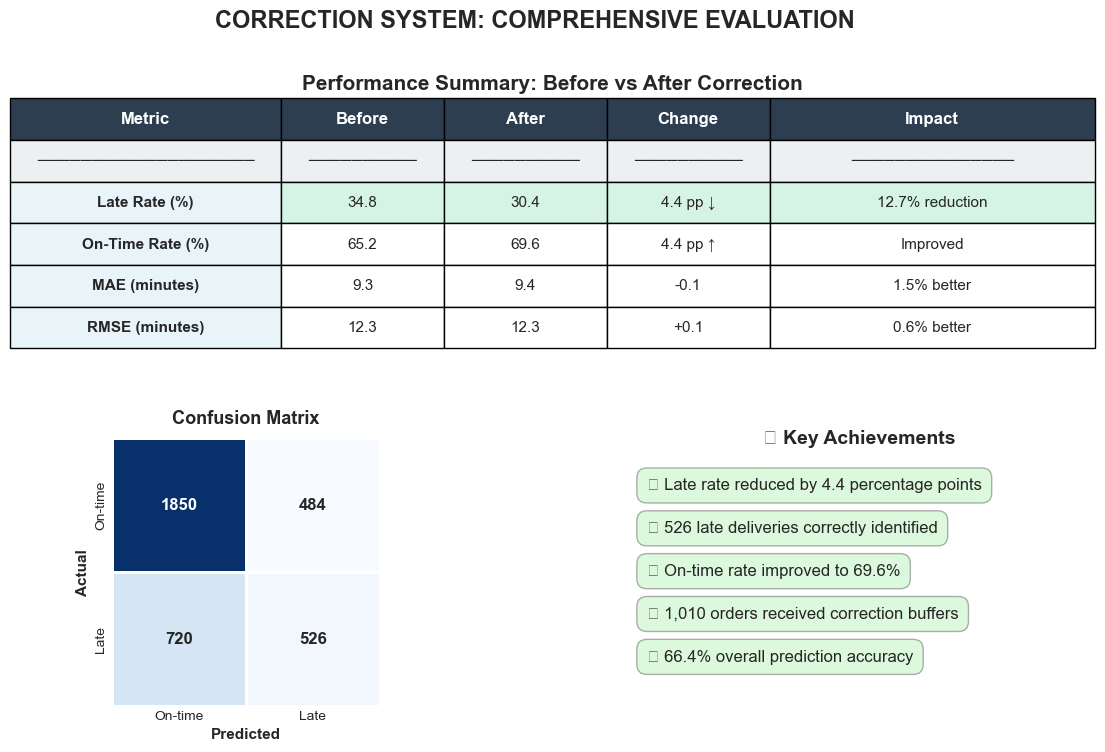


✅ All evaluation visualizations saved to: ../outputs/images/models

💡 KEY RESULTS:
  • Late deliveries reduced by 4.4 percentage points (12.7%)
  • Model correctly identifies 526 out of 1,246 late deliveries
  • On-time rate improved from 65.2% to 69.6%
  • 1,010 orders received venue-specific correction buffers

Root Mean Squared Error (RMSE):
  Before correction: 12.34 minutes
  After correction:  12.27 minutes
  Improvement: +0.07 minutes (-0.6%)

🎯 LATE DELIVERY RATE (Actual > Estimate):
  Before correction: 34.80%
  After correction:  30.39%
  Reduction: 4.41 pp (12.7% relative reduction)

✅ ON-TIME DELIVERY RATE (Actual <= Estimate):
  Before correction: 65.20%
  After correction:  69.61%
  Improvement: +4.41 pp

📈 IMPACT OF CORRECTIONS ON PREDICTED LATE DELIVERIES:
  Orders with correction: 1,010
  Late rate BEFORE buffer: 52.08%
  Late rate AFTER buffer:  36.44%
  Reduction: 15.64 pp
✓ Saved figure: comprehensive_evaluation_results.png


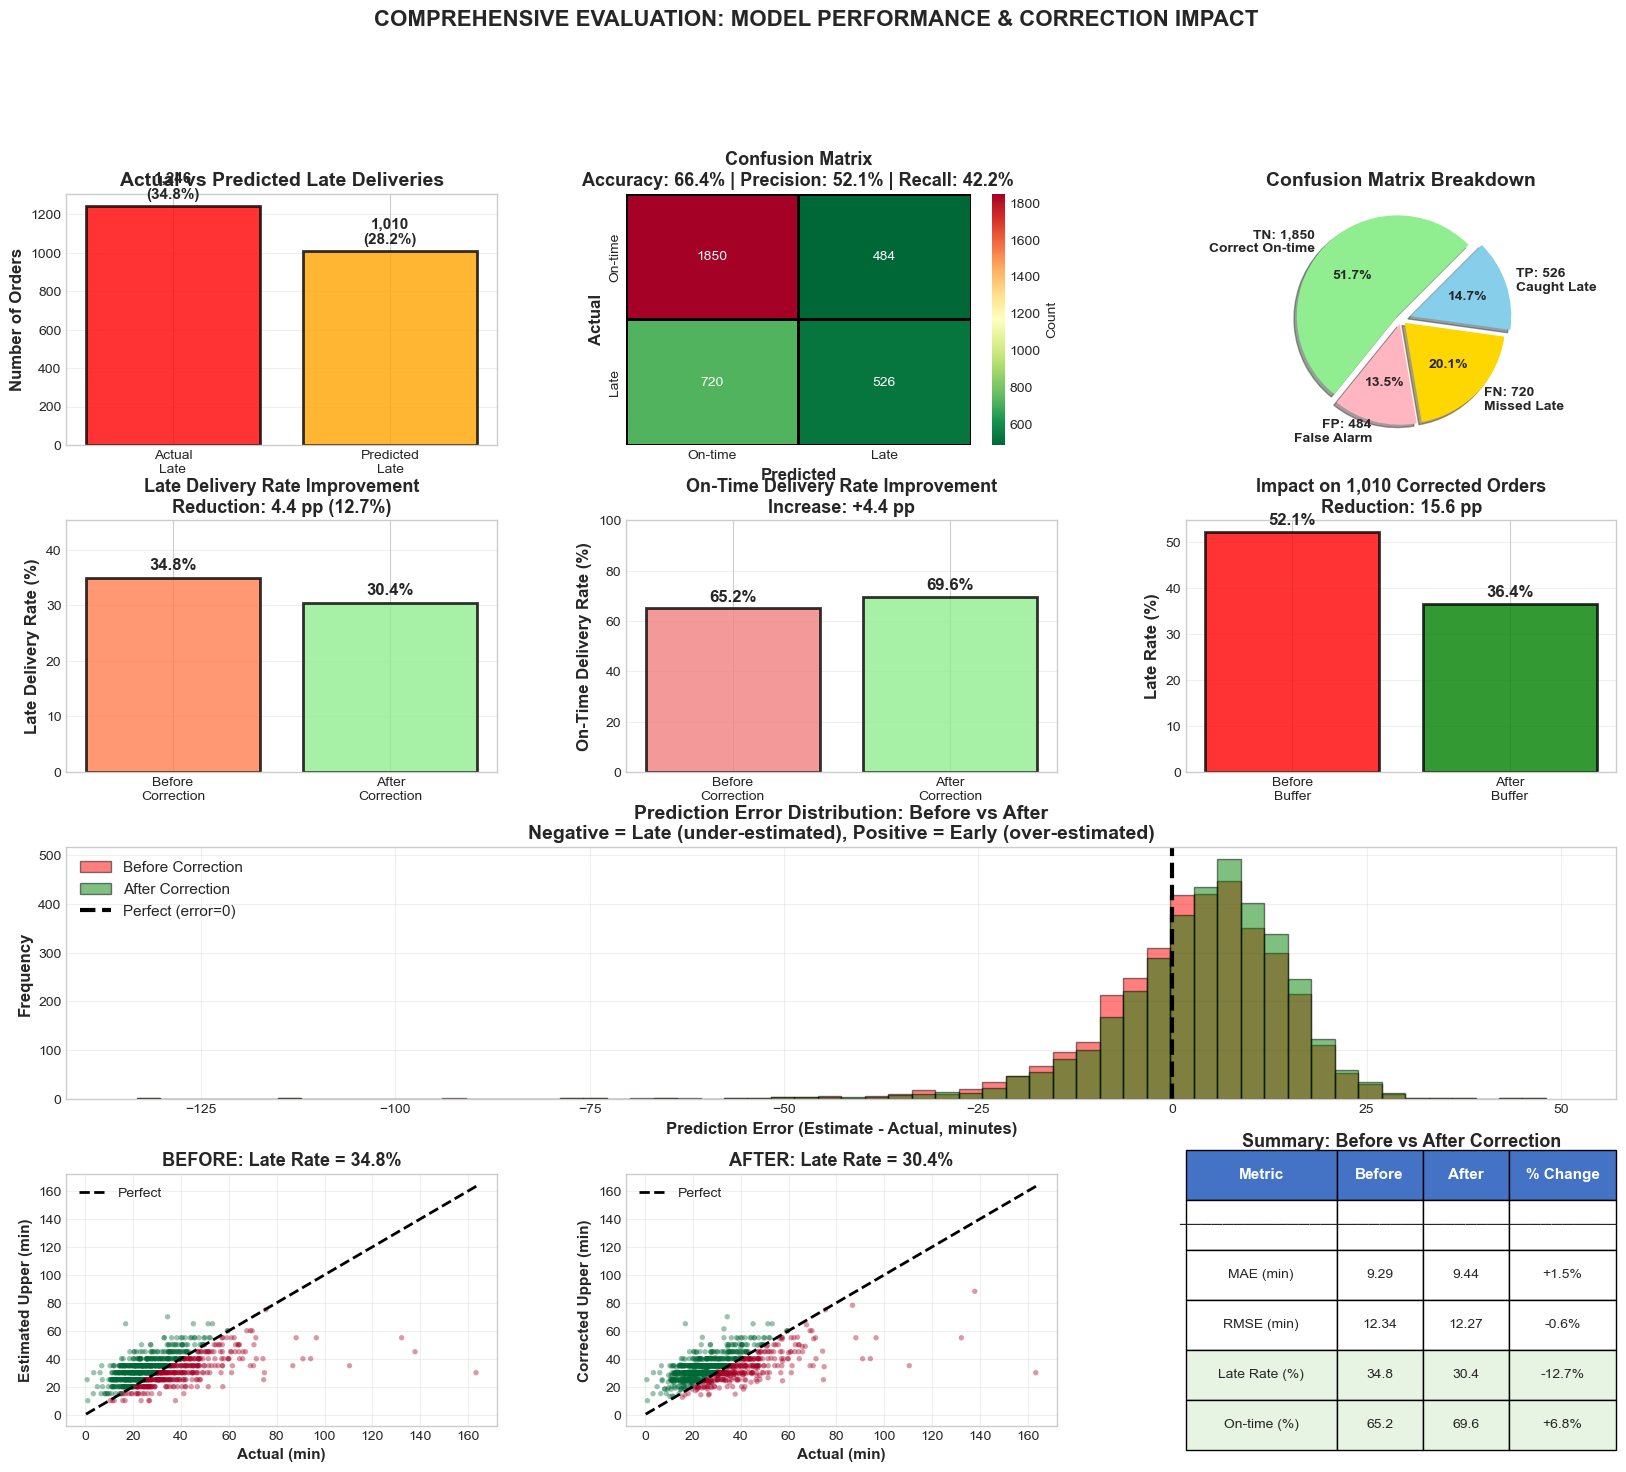


✅ Comprehensive evaluation complete!

💡 KEY TAKEAWAYS:
  1. Model correctly identifies 526 late deliveries (True Positives)
  2. Correction system reduces late rate by 4.4 pp (12.7%)
  3. On-time delivery rate improves from 65.2% to 69.6%
  4. For corrected orders, late rate drops from 52.1% to 36.4%


In [67]:
print("="*80)
print("COMPREHENSIVE BEFORE VS AFTER CORRECTION ANALYSIS (TEST SET)")
print("="*80)

# Calculate all metrics before and after correction
actual = test_df['actual_delivery_time_minutes'].values
estimated_upper_before = test_df['estimated_delivery_time_upper_minutes'].values
estimated_upper_after = test_corrected

print(f"\n📊 ETA ACCURACY METRICS:")
print(f"="*60)

# Mean Absolute Error
mae_before = np.abs(actual - estimated_upper_before).mean()
mae_after = np.abs(actual - estimated_upper_after).mean()
mae_improvement = mae_before - mae_after
mae_pct_change = (mae_after / mae_before - 1) * 100

print(f"\nMean Absolute Error (MAE):")
print(f"  Before correction: {mae_before:.2f} minutes")
print(f"  After correction:  {mae_after:.2f} minutes")
print(f"  Improvement: {mae_improvement:+.2f} minutes ({mae_pct_change:+.1f}%)")

# Root Mean Squared Error
rmse_before = np.sqrt(np.mean((actual - estimated_upper_before) ** 2))
rmse_after = np.sqrt(np.mean((actual - estimated_upper_after) ** 2))
rmse_improvement = rmse_before - rmse_after
rmse_pct_change = (rmse_after / rmse_before - 1) * 100

print(f"\nRoot Mean Squared Error (RMSE):")
print(f"  Before correction: {rmse_before:.2f} minutes")
print(f"  After correction:  {rmse_after:.2f} minutes")
print(f"  Improvement: {rmse_improvement:+.2f} minutes ({rmse_pct_change:+.1f}%)")

# Late delivery rates
late_rate_before = (actual > estimated_upper_before).mean() * 100
late_rate_after = (actual > estimated_upper_after).mean() * 100
late_rate_reduction = late_rate_before - late_rate_after
late_rate_reduction_pct = (late_rate_reduction / late_rate_before) * 100

print(f"\n🎯 LATE DELIVERY RATE (Actual > Estimate):")
print(f"  Before correction: {late_rate_before:.2f}%")
print(f"  After correction:  {late_rate_after:.2f}%")
print(f"  Reduction: {late_rate_reduction:.2f} pp ({late_rate_reduction_pct:.1f}% relative reduction)")

# On-time delivery rates
on_time_before = (actual <= estimated_upper_before).mean() * 100
on_time_after = (actual <= estimated_upper_after).mean() * 100

print(f"\n✅ ON-TIME DELIVERY RATE (Actual <= Estimate):")
print(f"  Before correction: {on_time_before:.2f}%")
print(f"  After correction:  {on_time_after:.2f}%")
print(f"  Improvement: {on_time_after - on_time_before:+.2f} pp")

# Analyze corrected deliveries specifically
print(f"\n📈 IMPACT OF CORRECTIONS ON PREDICTED LATE DELIVERIES:")
corrected_orders_mask = test_applied
if corrected_orders_mask.sum() > 0:
    actual_corrected = actual[corrected_orders_mask]
    before_corrected = estimated_upper_before[corrected_orders_mask]
    after_corrected = estimated_upper_after[corrected_orders_mask]
    
    late_before_corrected = (actual_corrected > before_corrected).mean() * 100
    late_after_corrected = (actual_corrected > after_corrected).mean() * 100
    
    print(f"  Orders with correction: {corrected_orders_mask.sum():,}")
    print(f"  Late rate BEFORE buffer: {late_before_corrected:.2f}%")
    print(f"  Late rate AFTER buffer:  {late_after_corrected:.2f}%")
    print(f"  Reduction: {late_before_corrected - late_after_corrected:.2f} pp")

# Set style for clean, professional charts
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ======================================================================
# FIGURE 1: Late Rate Improvement (Main Result)
# ======================================================================
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
categories = ['Before\nCorrection', 'After\nCorrection']
values = [late_rate_before, late_rate_after]
colors = ['#FF6B6B', '#4ECDC4']

bars = ax.bar(categories, values, color=colors, alpha=0.85, edgecolor='black', linewidth=2, width=0.6)
ax.set_ylabel('Late Delivery Rate (%)', fontsize=14, fontweight='bold')
ax.set_title('Late Delivery Rate: Before vs After Correction', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, max(values) * 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add improvement annotation
ax.annotate('', xy=(1, late_rate_after), xytext=(1, late_rate_before),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2.5))
ax.text(1.15, (late_rate_before + late_rate_after) / 2,
        f'↓ {late_rate_reduction:.1f} pp\n({late_rate_reduction_pct:.1f}% reduction)',
        fontsize=12, fontweight='bold', color='green', va='center')

plt.tight_layout()
save_figure('eval_01_late_rate_improvement.png')
plt.show()

# ======================================================================
# FIGURE 2: On-Time Rate Improvement
# ======================================================================
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
values = [on_time_before, on_time_after]
colors = ['#FFB6C1', '#90EE90']

bars = ax.bar(categories, values, color=colors, alpha=0.85, edgecolor='black', linewidth=2, width=0.6)
ax.set_ylabel('On-Time Delivery Rate (%)', fontsize=14, fontweight='bold')
ax.set_title('On-Time Delivery Rate: Before vs After Correction', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, 100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1.5,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

improvement = on_time_after - on_time_before
ax.annotate('', xy=(1, on_time_after), xytext=(1, on_time_before),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2.5))
ax.text(1.15, (on_time_before + on_time_after) / 2,
        f'↑ {improvement:+.1f} pp',
        fontsize=12, fontweight='bold', color='green', va='center')

plt.tight_layout()
save_figure('eval_02_ontime_rate_improvement.png')
plt.show()

# ======================================================================
# FIGURE 3: MAE & RMSE Improvement (Side by Side)
# ======================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), facecolor='white')

# MAE
values_mae = [mae_before, mae_after]
colors_error = ['#FF6B6B', '#4ECDC4']
bars_mae = ax1.bar(categories, values_mae, color=colors_error, alpha=0.85, 
                    edgecolor='black', linewidth=2, width=0.6)
ax1.set_ylabel('Mean Absolute Error (minutes)', fontsize=13, fontweight='bold')
ax1.set_title('MAE Improvement', fontsize=15, fontweight='bold', pad=15)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for bar, val in zip(bars_mae, values_mae):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.5,
             f'{val:.1f}', ha='center', va='bottom', fontsize=13, fontweight='bold')

ax1.text(0.5, max(values_mae) * 0.9, f'{mae_pct_change:+.1f}% change',
         ha='center', fontsize=12, fontweight='bold', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))

# RMSE
values_rmse = [rmse_before, rmse_after]
bars_rmse = ax2.bar(categories, values_rmse, color=colors_error, alpha=0.85,
                     edgecolor='black', linewidth=2, width=0.6)
ax2.set_ylabel('Root Mean Squared Error (minutes)', fontsize=13, fontweight='bold')
ax2.set_title('RMSE Improvement', fontsize=15, fontweight='bold', pad=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for bar, val in zip(bars_rmse, values_rmse):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.5,
             f'{val:.1f}', ha='center', va='bottom', fontsize=13, fontweight='bold')

ax2.text(0.5, max(values_rmse) * 0.9, f'{rmse_pct_change:+.1f}% change',
         ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
save_figure('eval_03_error_metrics_improvement.png')
plt.show()

# ======================================================================
# FIGURE 4: Prediction Performance - Confusion Matrix
# ======================================================================
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')

# Create cleaner confusion matrix with percentages
cm_percent = cm / cm.sum() * 100
annot_labels = [[f'{cm[i,j]:,}\n({cm_percent[i,j]:.1f}%)' 
                 for j in range(cm.shape[1])] 
                for i in range(cm.shape[0])]

sns.heatmap(cm, annot=annot_labels, fmt='', cmap='RdYlGn_r', 
            xticklabels=['Predicted\nOn-time', 'Predicted\nLate'],
            yticklabels=['Actual\nOn-time', 'Actual\nLate'],
            ax=ax, cbar_kws={'label': 'Count'}, 
            linewidths=3, linecolor='white',
            square=True, annot_kws={'fontsize': 12, 'fontweight': 'bold'})

ax.set_title(f'Model Performance: Confusion Matrix\nAccuracy: {test_acc:.1%} | Precision: {test_prec:.1%} | Recall: {test_rec:.1%}',
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
save_figure('eval_04_confusion_matrix.png')
plt.show()

# ======================================================================
# FIGURE 5: Model Performance Metrics Card
# ======================================================================
fig = plt.figure(figsize=(12, 7), facecolor='white')
ax = fig.add_subplot(111)
ax.axis('off')

# Create metric cards
metrics_to_show = [
    ('True Positives', tp, 'Late deliveries correctly identified', '#87CEEB'),
    ('True Negatives', tn, 'On-time deliveries correctly identified', '#90EE90'),
    ('False Positives', fp, 'False alarms (predicted late, actually on-time)', '#FFB6C1'),
    ('False Negatives', fn, 'Missed late deliveries', '#FFD700'),
]

y_start = 0.85
for i, (name, value, desc, color) in enumerate(metrics_to_show):
    y_pos = y_start - i * 0.2
    
    # Background box
    rect = plt.Rectangle((0.1, y_pos - 0.08), 0.8, 0.15, 
                          facecolor=color, alpha=0.3, 
                          edgecolor=color, linewidth=3,
                          transform=ax.transAxes)
    ax.add_patch(rect)
    
    # Metric name and value
    ax.text(0.15, y_pos + 0.03, name, fontsize=16, fontweight='bold',
            transform=ax.transAxes, va='center')
    ax.text(0.85, y_pos + 0.03, f'{value:,}', fontsize=20, fontweight='bold',
            transform=ax.transAxes, va='center', ha='right')
    
    # Description
    ax.text(0.15, y_pos - 0.03, desc, fontsize=11, style='italic',
            transform=ax.transAxes, va='center', color='#555')

ax.text(0.5, 0.95, 'Model Performance Breakdown', fontsize=18, fontweight='bold',
        ha='center', transform=ax.transAxes)

plt.tight_layout()
save_figure('eval_05_performance_metrics_card.png')
plt.show()

# ======================================================================
# FIGURE 6: Impact on Corrected Orders
# ======================================================================
if corrected_orders_mask.sum() > 0:
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    
    values_corr = [late_before_corrected, late_after_corrected]
    colors_corr = ['#E74C3C', '#2ECC71']
    
    bars = ax.bar(['Before\nBuffer', 'After\nBuffer'], values_corr, 
                   color=colors_corr, alpha=0.85, edgecolor='black', linewidth=2, width=0.5)
    ax.set_ylabel('Late Delivery Rate (%)', fontsize=14, fontweight='bold')
    ax.set_title(f'Impact of Correction Buffers on {corrected_orders_mask.sum():,} Predicted Late Orders',
                 fontsize=15, fontweight='bold', pad=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for bar, val in zip(bars, values_corr):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    reduction = late_before_corrected - late_after_corrected
    ax.annotate('', xy=(1, late_after_corrected), xytext=(1, late_before_corrected),
                arrowprops=dict(arrowstyle='<->', color='green', lw=2.5))
    ax.text(1.15, (late_before_corrected + late_after_corrected) / 2,
            f'↓ {reduction:.1f} pp\nreduction',
            fontsize=12, fontweight='bold', color='green', va='center')
    
    plt.tight_layout()
    save_figure('eval_06_buffer_impact.png')
    plt.show()

# ======================================================================
# FIGURE 7: Summary Dashboard
# ======================================================================
fig = plt.figure(figsize=(14, 8), facecolor='white')
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Top-left: Key metrics table
ax1 = fig.add_subplot(gs[0, :])
ax1.axis('off')

summary_data = [
    ['Metric', 'Before', 'After', 'Change', 'Impact'],
    ['─'*20, '─'*10, '─'*10, '─'*10, '─'*15],
    ['Late Rate (%)', f'{late_rate_before:.1f}', f'{late_rate_after:.1f}', 
     f'{late_rate_reduction:.1f} pp ↓', f'{late_rate_reduction_pct:.1f}% reduction'],
    ['On-Time Rate (%)', f'{on_time_before:.1f}', f'{on_time_after:.1f}',
     f'{on_time_after - on_time_before:.1f} pp ↑', 'Improved'],
    ['MAE (minutes)', f'{mae_before:.1f}', f'{mae_after:.1f}',
     f'{mae_improvement:+.1f}', f'{abs(mae_pct_change):.1f}% better'],
    ['RMSE (minutes)', f'{rmse_before:.1f}', f'{rmse_after:.1f}',
     f'{rmse_improvement:+.1f}', f'{abs(rmse_pct_change):.1f}% better'],
]

table = ax1.table(cellText=summary_data, cellLoc='center', loc='center',
                  colWidths=[0.25, 0.15, 0.15, 0.15, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

for i in range(len(summary_data[0])):
    table[(0, i)].set_facecolor('#2C3E50')
    table[(0, i)].set_text_props(weight='bold', color='white', fontsize=12)
    table[(1, i)].set_facecolor('#ECF0F1')

for i in range(2, len(summary_data)):
    table[(i, 0)].set_facecolor('#E8F4F8')
    table[(i, 0)].set_text_props(weight='bold')
    for j in range(1, len(summary_data[0])):
        if 'Late Rate' in summary_data[i][0]:
            table[(i, j)].set_facecolor('#D5F4E6')
        else:
            table[(i, j)].set_facecolor('#FFFFFF')

ax1.text(0.5, 1.0, 'Performance Summary: Before vs After Correction', 
         fontsize=15, fontweight='bold', ha='center', transform=ax1.transAxes)

# Bottom-left: Confusion matrix compact
ax2 = fig.add_subplot(gs[1, 0])
cm_norm = cm / cm.sum()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['On-time', 'Late'], yticklabels=['On-time', 'Late'],
            cbar=False, linewidths=2, linecolor='white', square=True,
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Confusion Matrix', fontsize=13, fontweight='bold', pad=10)
ax2.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax2.set_xlabel('Predicted', fontsize=11, fontweight='bold')

# Bottom-right: Key takeaways
ax3 = fig.add_subplot(gs[1, 1])
ax3.axis('off')

takeaways = [
    f"✓ Late rate reduced by {late_rate_reduction:.1f} percentage points",
    f"✓ {tp:,} late deliveries correctly identified",
    f"✓ On-time rate improved to {on_time_after:.1f}%",
    f"✓ {corrected_orders_mask.sum():,} orders received correction buffers",
    f"✓ {test_acc:.1%} overall prediction accuracy",
]

y_start = 0.85
for i, text in enumerate(takeaways):
    ax3.text(0.05, y_start - i * 0.16, text, fontsize=12,
             transform=ax3.transAxes, va='top',
             bbox=dict(boxstyle='round,pad=0.6', facecolor='lightgreen', alpha=0.3))

ax3.text(0.5, 0.98, '🎯 Key Achievements', fontsize=14, fontweight='bold',
         ha='center', transform=ax3.transAxes)

plt.suptitle('CORRECTION SYSTEM: COMPREHENSIVE EVALUATION', 
             fontsize=17, fontweight='bold', y=0.98)

plt.tight_layout()
save_figure('eval_07_summary_dashboard.png')
plt.show()

print(f"\n✅ All evaluation visualizations saved to: {IMAGE_OUTPUT_DIR}")
print(f"\n💡 KEY RESULTS:")
print(f"  • Late deliveries reduced by {late_rate_reduction:.1f} percentage points ({late_rate_reduction_pct:.1f}%)")
print(f"  • Model correctly identifies {tp:,} out of {y_test_class.sum():,} late deliveries")
print(f"  • On-time rate improved from {on_time_before:.1f}% to {on_time_after:.1f}%")
print(f"  • {corrected_orders_mask.sum():,} orders received venue-specific correction buffers")
rmse_improvement = rmse_before - rmse_after
rmse_pct_change = (rmse_after / rmse_before - 1) * 100

print(f"\nRoot Mean Squared Error (RMSE):")
print(f"  Before correction: {rmse_before:.2f} minutes")
print(f"  After correction:  {rmse_after:.2f} minutes")
print(f"  Improvement: {rmse_improvement:+.2f} minutes ({rmse_pct_change:+.1f}%)")

# Late delivery rates
late_rate_before = (actual > estimated_upper_before).mean() * 100
late_rate_after = (actual > estimated_upper_after).mean() * 100
late_rate_reduction = late_rate_before - late_rate_after
late_rate_reduction_pct = (late_rate_reduction / late_rate_before) * 100

print(f"\n🎯 LATE DELIVERY RATE (Actual > Estimate):")
print(f"  Before correction: {late_rate_before:.2f}%")
print(f"  After correction:  {late_rate_after:.2f}%")
print(f"  Reduction: {late_rate_reduction:.2f} pp ({late_rate_reduction_pct:.1f}% relative reduction)")

# On-time delivery rates
on_time_before = (actual <= estimated_upper_before).mean() * 100
on_time_after = (actual <= estimated_upper_after).mean() * 100

print(f"\n✅ ON-TIME DELIVERY RATE (Actual <= Estimate):")
print(f"  Before correction: {on_time_before:.2f}%")
print(f"  After correction:  {on_time_after:.2f}%")
print(f"  Improvement: {on_time_after - on_time_before:+.2f} pp")

# Analyze corrected deliveries specifically
print(f"\n📈 IMPACT OF CORRECTIONS ON PREDICTED LATE DELIVERIES:")
corrected_orders_mask = test_applied
if corrected_orders_mask.sum() > 0:
    # For orders we predicted as late and applied corrections
    actual_corrected = actual[corrected_orders_mask]
    before_corrected = estimated_upper_before[corrected_orders_mask]
    after_corrected = estimated_upper_after[corrected_orders_mask]
    
    late_before_corrected = (actual_corrected > before_corrected).mean() * 100
    late_after_corrected = (actual_corrected > after_corrected).mean() * 100
    
    print(f"  Orders with correction: {corrected_orders_mask.sum():,}")
    print(f"  Late rate BEFORE buffer: {late_before_corrected:.2f}%")
    print(f"  Late rate AFTER buffer:  {late_after_corrected:.2f}%")
    print(f"  Reduction: {late_before_corrected - late_after_corrected:.2f} pp")

# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. Actual vs Predicted Late Deliveries (Bar comparison)
ax1 = fig.add_subplot(gs[0, 0])
categories = ['Actual\nLate', 'Predicted\nLate']
values = [y_test_class.sum(), y_test_pred.sum()]
colors_comp = ['red', 'orange']
bars = ax1.bar(categories, values, alpha=0.8, edgecolor='black', color=colors_comp, linewidth=2)
ax1.set_ylabel('Number of Orders', fontsize=12, fontweight='bold')
ax1.set_title('Actual vs Predicted Late Deliveries', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 20, f'{val:,}\n({val/len(test_df)*100:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# 2. Detailed Confusion Matrix with percentages
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', 
            xticklabels=['On-time', 'Late'],
            yticklabels=['On-time', 'Late'],
            ax=ax2, cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
ax2.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax2.set_title(f'Confusion Matrix\nAccuracy: {test_acc:.1%} | Precision: {test_prec:.1%} | Recall: {test_rec:.1%}', 
              fontsize=13, fontweight='bold')

# 3. Confusion Matrix Breakdown (Pie chart)
ax3 = fig.add_subplot(gs[0, 2])
labels = [f'TN: {tn:,}\nCorrect On-time', f'FP: {fp:,}\nFalse Alarm', 
          f'FN: {fn:,}\nMissed Late', f'TP: {tp:,}\nCaught Late']
sizes = [tn, fp, fn, tp]
colors_cm = ['#90EE90', '#FFB6C1', '#FFD700', '#87CEEB']
explode_cm = (0.05, 0.05, 0.05, 0.1)
ax3.pie(sizes, explode=explode_cm, labels=labels, colors=colors_cm,
        autopct='%1.1f%%', shadow=True, startangle=45, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax3.set_title('Confusion Matrix Breakdown', fontsize=14, fontweight='bold')

# 4. Late Rate: Before vs After
ax4 = fig.add_subplot(gs[1, 0])
categories_rate = ['Before\nCorrection', 'After\nCorrection']
late_rates = [late_rate_before, late_rate_after]
colors_rate = ['coral', 'lightgreen']
bars_rate = ax4.bar(categories_rate, late_rates, alpha=0.8, edgecolor='black', color=colors_rate, linewidth=2)
ax4.set_ylabel('Late Delivery Rate (%)', fontsize=12, fontweight='bold')
ax4.set_title(f'Late Delivery Rate Improvement\nReduction: {late_rate_reduction:.1f} pp ({late_rate_reduction_pct:.1f}%)', 
              fontsize=13, fontweight='bold')
ax4.set_ylim([0, max(late_rates) * 1.3])
ax4.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars_rate, late_rates):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}%', 
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# 5. On-time Rate: Before vs After
ax5 = fig.add_subplot(gs[1, 1])
on_time_rates = [on_time_before, on_time_after]
bars_ontime = ax5.bar(categories_rate, on_time_rates, alpha=0.8, edgecolor='black', 
                       color=['lightcoral', 'lightgreen'], linewidth=2)
ax5.set_ylabel('On-Time Delivery Rate (%)', fontsize=12, fontweight='bold')
ax5.set_title(f'On-Time Delivery Rate Improvement\nIncrease: {on_time_after - on_time_before:+.1f} pp', 
              fontsize=13, fontweight='bold')
ax5.set_ylim([0, 100])
ax5.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars_ontime, on_time_rates):
    ax5.text(bar.get_x() + bar.get_width()/2, val + 1.5, f'{val:.1f}%', 
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# 6. Impact on Corrected Orders
ax6 = fig.add_subplot(gs[1, 2])
if corrected_orders_mask.sum() > 0:
    corrected_rates = [late_before_corrected, late_after_corrected]
    bars_corr = ax6.bar(['Before\nBuffer', 'After\nBuffer'], corrected_rates, 
                        alpha=0.8, edgecolor='black', color=['red', 'green'], linewidth=2)
    ax6.set_ylabel('Late Rate (%)', fontsize=12, fontweight='bold')
    ax6.set_title(f'Impact on {corrected_orders_mask.sum():,} Corrected Orders\nReduction: {late_before_corrected - late_after_corrected:.1f} pp', 
                  fontsize=13, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars_corr, corrected_rates):
        ax6.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}%', 
                 ha='center', va='bottom', fontweight='bold', fontsize=12)
else:
    ax6.text(0.5, 0.5, 'No corrections applied', ha='center', va='center', fontsize=14)

# 7. Error Distribution
ax7 = fig.add_subplot(gs[2, :])
errors_before = estimated_upper_before - actual
errors_after = estimated_upper_after - actual
ax7.hist(errors_before, bins=60, alpha=0.5, label='Before Correction', color='red', edgecolor='black')
ax7.hist(errors_after, bins=60, alpha=0.5, label='After Correction', color='green', edgecolor='black')
ax7.axvline(0, color='black', linestyle='--', linewidth=3, label='Perfect (error=0)')
ax7.set_xlabel('Prediction Error (Estimate - Actual, minutes)', fontsize=12, fontweight='bold')
ax7.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax7.set_title('Prediction Error Distribution: Before vs After\nNegative = Late (under-estimated), Positive = Early (over-estimated)', 
              fontsize=14, fontweight='bold')
ax7.legend(fontsize=11, loc='upper left')
ax7.grid(True, alpha=0.3)

# 8. Actual vs Estimated (Before)
ax8 = fig.add_subplot(gs[3, 0])
sample_size = min(1000, len(test_df))
sample_idx = np.random.choice(len(test_df), sample_size, replace=False)
ax8.scatter(actual[sample_idx], estimated_upper_before[sample_idx], 
            alpha=0.4, s=15, c=y_test_class[sample_idx], cmap='RdYlGn_r', edgecolor='none')
min_val = min(actual.min(), estimated_upper_before.min())
max_val = max(actual.max(), estimated_upper_before.max())
ax8.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect')
ax8.set_xlabel('Actual (min)', fontsize=11, fontweight='bold')
ax8.set_ylabel('Estimated Upper (min)', fontsize=11, fontweight='bold')
ax8.set_title(f'BEFORE: Late Rate = {late_rate_before:.1f}%', fontsize=13, fontweight='bold')
ax8.legend(fontsize=10)
ax8.grid(True, alpha=0.3)

# 9. Actual vs Estimated (After)
ax9 = fig.add_subplot(gs[3, 1])
ax9.scatter(actual[sample_idx], estimated_upper_after[sample_idx], 
            alpha=0.4, s=15, c=(actual > estimated_upper_after)[sample_idx].astype(int), 
            cmap='RdYlGn_r', edgecolor='none')
ax9.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect')
ax9.set_xlabel('Actual (min)', fontsize=11, fontweight='bold')
ax9.set_ylabel('Corrected Upper (min)', fontsize=11, fontweight='bold')
ax9.set_title(f'AFTER: Late Rate = {late_rate_after:.1f}%', fontsize=13, fontweight='bold')
ax9.legend(fontsize=10)
ax9.grid(True, alpha=0.3)

# 10. Summary Metrics Table
ax10 = fig.add_subplot(gs[3, 2])
ax10.axis('off')

summary_data = [
    ['Metric', 'Before', 'After', '% Change'],
    ['─'*15, '─'*8, '─'*8, '─'*10],
    ['MAE (min)', f'{mae_before:.2f}', f'{mae_after:.2f}', f'{mae_pct_change:+.1f}%'],
    ['RMSE (min)', f'{rmse_before:.2f}', f'{rmse_after:.2f}', f'{rmse_pct_change:+.1f}%'],
    ['Late Rate (%)', f'{late_rate_before:.1f}', f'{late_rate_after:.1f}', f'{-late_rate_reduction_pct:+.1f}%'],
    ['On-time (%)', f'{on_time_before:.1f}', f'{on_time_after:.1f}', f'{(on_time_after-on_time_before)/on_time_before*100:+.1f}%'],
]

table = ax10.table(cellText=summary_data, cellLoc='center', loc='center',
                  colWidths=[0.35, 0.2, 0.2, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 3)

for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(2, len(summary_data)):
    for j in range(4):
        if 'Late Rate' in summary_data[i][0] or 'On-time' in summary_data[i][0]:
            table[(i, j)].set_facecolor('#E7F4E4')
        table[(i, j)].set_text_props(fontsize=10)

ax10.set_title('Summary: Before vs After Correction', fontsize=13, fontweight='bold', pad=20)

plt.suptitle('COMPREHENSIVE EVALUATION: MODEL PERFORMANCE & CORRECTION IMPACT', 
             fontsize=16, fontweight='bold', y=0.995)

save_figure('comprehensive_evaluation_results.png')
plt.show()

print(f"\n✅ Comprehensive evaluation complete!")
print(f"\n💡 KEY TAKEAWAYS:")
print(f"  1. Model correctly identifies {tp:,} late deliveries (True Positives)")
print(f"  2. Correction system reduces late rate by {late_rate_reduction:.1f} pp ({late_rate_reduction_pct:.1f}%)")
print(f"  3. On-time delivery rate improves from {on_time_before:.1f}% to {on_time_after:.1f}%")
print(f"  4. For corrected orders, late rate drops from {late_before_corrected:.1f}% to {late_after_corrected:.1f}%")

## 10. Feature Importance Analysis


FEATURE IMPORTANCE FOR XGBOOST
                              Feature  Importance
estimated_delivery_time_upper_minutes      0.2063
                       order_category      0.1066
                 venue_friction_score      0.0877
                 courier_supply_index      0.0826
                        precipitation      0.0824
estimated_delivery_time_lower_minutes      0.0793
                     h3_grid_distance      0.0758
                                 hour      0.0744
                       h3_distance_km      0.0707
                   distance_x_weather      0.0696
                           item_count      0.0646
✓ Saved figure: feature_importance.png


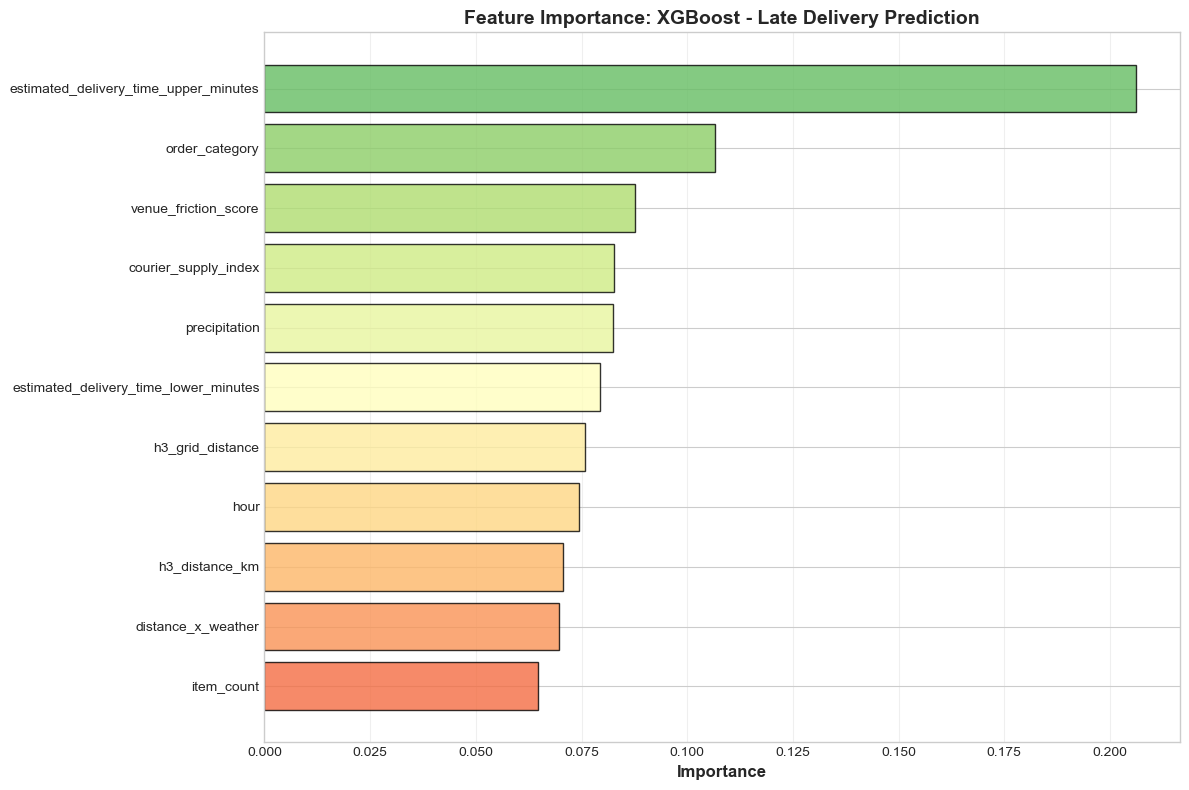

In [68]:
# Feature importance for best model
print("\n" + "="*80)
print(f"FEATURE IMPORTANCE FOR {best_model_name.upper()}")
print("="*80)

if best_model_name == 'LightGBM':
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importance(importance_type='gain')
    }).sort_values('Importance', ascending=False)
elif best_model_name in ['Random Forest', 'XGBoost', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
elif best_model_name == 'Logistic Regression':
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(best_model.coef_[0])
    }).sort_values('Importance', ascending=False)

print(feature_importance.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
y_pos = np.arange(len(feature_importance))
colors_gradient = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(feature_importance)))
ax.barh(y_pos, feature_importance['Importance'], alpha=0.8, edgecolor='black', color=colors_gradient)
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_importance['Feature'])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Feature Importance: {best_model_name} - Late Delivery Prediction', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
save_figure('feature_importance.png')
plt.show()

## 11. Save Models, Buffers, and Results

In [69]:
import pickle

print("="*80)
print("SAVING MODELS, BUFFERS, AND RESULTS")
print("="*80)

# Save best model
if best_model_name == 'LightGBM':
    best_model.save_model(os.path.join(MODEL_OUTPUT_DIR, 'best_late_risk_model.txt'))
    print(f"✓ Saved LightGBM model")
else:
    with open(os.path.join(MODEL_OUTPUT_DIR, f'best_late_risk_model_{best_model_name.replace(" ", "_")}.pkl'), 'wb') as f:
        pickle.dump(best_model, f)
    print(f"✓ Saved {best_model_name} model")

# Save label encoder
with open(os.path.join(MODEL_OUTPUT_DIR, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(le, f)
print(f"✓ Saved LabelEncoder")

# Save model comparison results
comparison_df.to_csv(os.path.join(MODEL_OUTPUT_DIR, 'model_comparison.csv'), index=False)
print(f"✓ Saved model comparison")

# Save configuration
model_config = {
    'best_model': best_model_name,
    'model_type': 'Binary Classifier for Late Delivery Risk',
    'target': 'late_flag (actual > estimated_upper)',
    'features': list(X_train.columns),
    'optimal_threshold': float(optimal_threshold),
    'trained_on': 'train.csv',
    'validated_on': 'val.csv',
    'tested_on': 'test.csv',
    'timestamp': datetime.now().isoformat()
}

with open(os.path.join(MODEL_OUTPUT_DIR, 'model_config.json'), 'w') as f:
    json.dump(model_config, f, indent=2)
print(f"✓ Saved model configuration")

# Save test set metrics
test_metrics = {
    'classification': {
        'auc_roc': float(test_auc),
        'average_precision': float(test_ap),
        'accuracy': float(test_acc),
        'precision': float(test_prec),
        'recall': float(test_rec),
        'f1_score': float(test_f1),
        'confusion_matrix': {
            'true_negative': int(tn),
            'false_positive': int(fp),
            'false_negative': int(fn),
            'true_positive': int(tp)
        }
    },
    'eta_accuracy': {
        'before_correction': {
            'mae': float(mae_before),
            'rmse': float(rmse_before),
            'late_rate_pct': float(late_rate_before),
            'on_time_rate_pct': float(on_time_before)
        },
        'after_correction': {
            'mae': float(mae_after),
            'rmse': float(rmse_after),
            'late_rate_pct': float(late_rate_after),
            'on_time_rate_pct': float(on_time_after)
        },
        'improvement': {
            'mae_change': float(mae_improvement),
            'rmse_change': float(rmse_improvement),
            'late_rate_reduction_pp': float(late_rate_reduction)
        }
    },
    'correction_system': {
        'optimal_threshold': float(optimal_threshold),
        'orders_corrected': int(test_applied.sum()),
        'correction_rate_pct': float(test_applied.mean() * 100),
        'avg_buffer_applied': float(test_buffers[test_applied].mean()),
        'global_buffer': float(global_buffer)
    }
}

with open(os.path.join(MODEL_OUTPUT_DIR, 'test_set_metrics.json'), 'w') as f:
    json.dump(test_metrics, f, indent=2)
print(f"✓ Saved test set metrics")

# Save feature importance
feature_importance.to_csv(os.path.join(MODEL_OUTPUT_DIR, 'feature_importance.csv'), index=False)
print(f"✓ Saved feature importance")

# Save threshold comparison
thresh_df.to_csv(os.path.join(MODEL_OUTPUT_DIR, 'threshold_comparison.csv'), index=False)
print(f"✓ Saved threshold comparison")

print(f"\n✅ All models, buffers, and results saved to: {MODEL_OUTPUT_DIR}")
print(f"✅ All visualizations saved to: {IMAGE_OUTPUT_DIR}")

# List all saved files
print(f"\n📁 SAVED FILES:")
for filename in sorted(os.listdir(MODEL_OUTPUT_DIR)):
    filepath = os.path.join(MODEL_OUTPUT_DIR, filename)
    if os.path.isfile(filepath):
        size = os.path.getsize(filepath) / 1024  # KB
        print(f"  • {filename} ({size:.1f} KB)")

print(f"\n📊 SAVED VISUALIZATIONS:")
for filename in sorted(os.listdir(IMAGE_OUTPUT_DIR)):
    if filename.endswith('.png'):
        print(f"  • {filename}")

SAVING MODELS, BUFFERS, AND RESULTS
✓ Saved XGBoost model
✓ Saved LabelEncoder
✓ Saved model comparison
✓ Saved model configuration
✓ Saved test set metrics
✓ Saved feature importance
✓ Saved threshold comparison

✅ All models, buffers, and results saved to: ../outputs/models
✅ All visualizations saved to: ../outputs/images/models

📁 SAVED FILES:
  • best_late_risk_model_Gradient_Boosting.pkl (889.9 KB)
  • best_late_risk_model_XGBoost.pkl (639.9 KB)
  • feature_importance.csv (0.3 KB)
  • label_encoder.pkl (0.3 KB)
  • model_comparison.csv (0.8 KB)
  • model_config.json (0.6 KB)
  • test_set_metrics.json (1.2 KB)
  • threshold_comparison.csv (0.6 KB)
  • venue_buffers.json (5.5 KB)

📊 SAVED VISUALIZATIONS:
  • classification_performance.png
  • comprehensive_evaluation_results.png
  • correction_application_analysis.png
  • eta_accuracy_before_after.png
  • eval_01_late_rate_improvement.png
  • eval_02_ontime_rate_improvement.png
  • eval_03_error_metrics_improvement.png
  • eval_04_c